In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


<SkyCoord (ICRS): (ra, dec) in deg
    (153.94930833, -27.37438056)>
number of sources: 93


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


4 sigma detections: 43


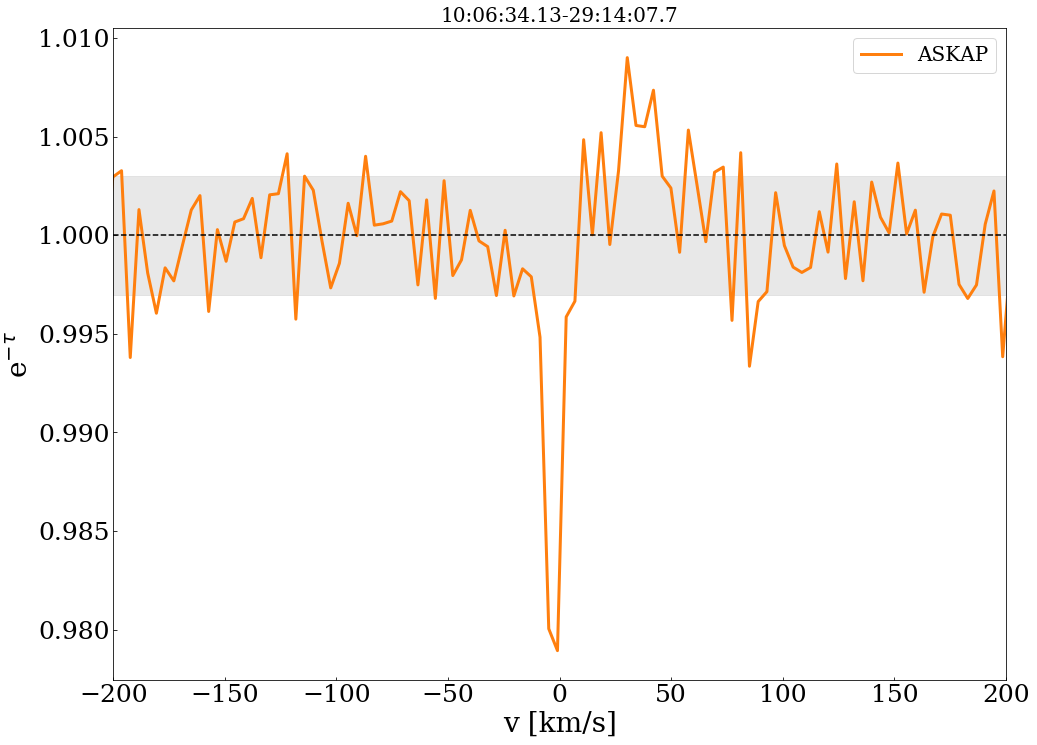

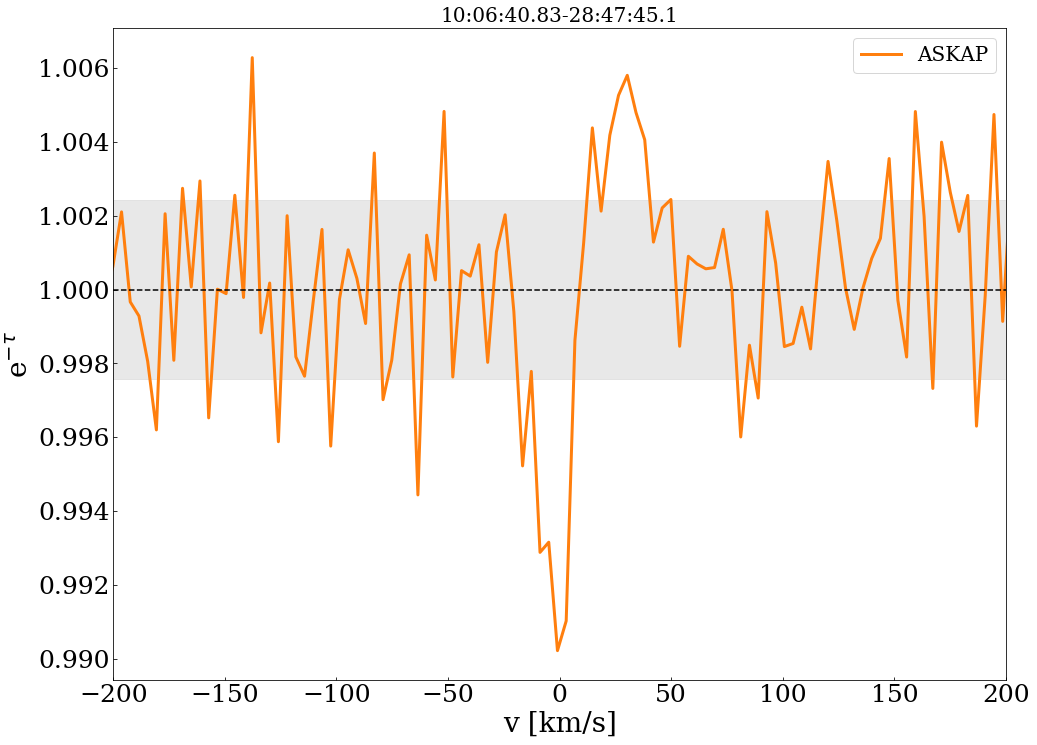

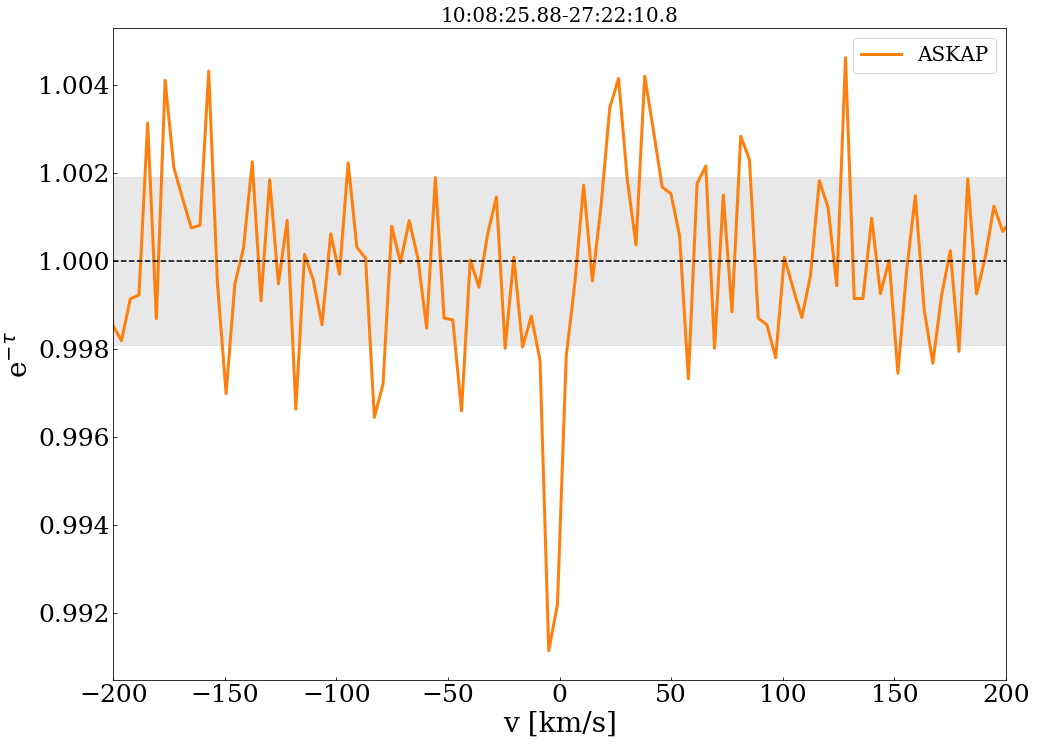

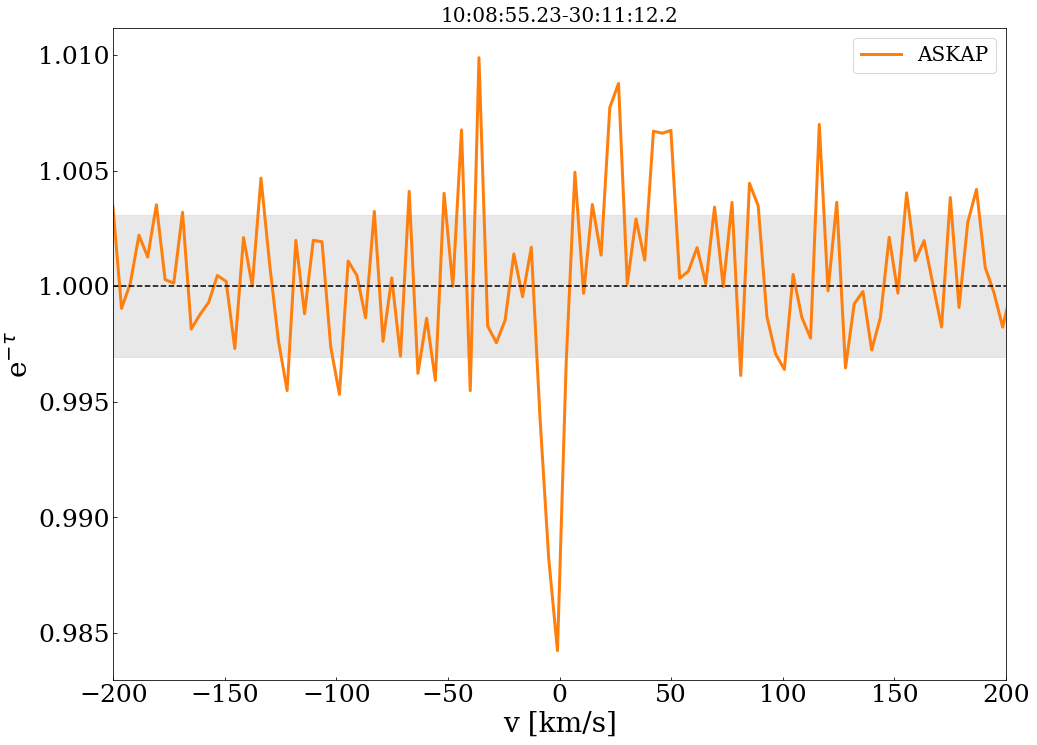

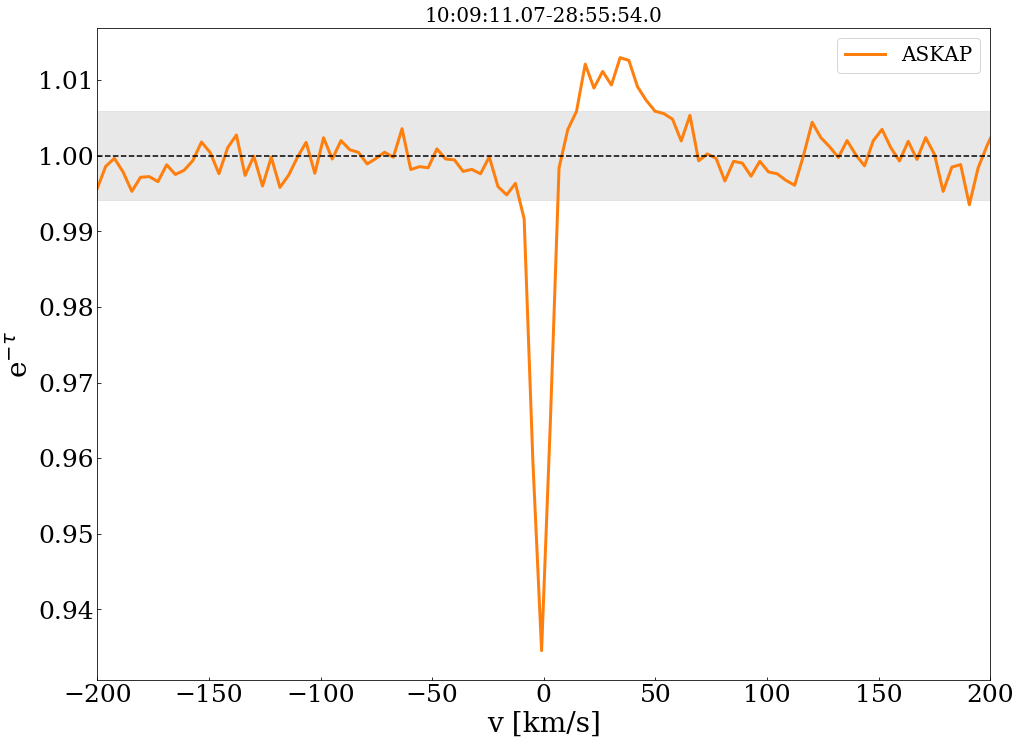

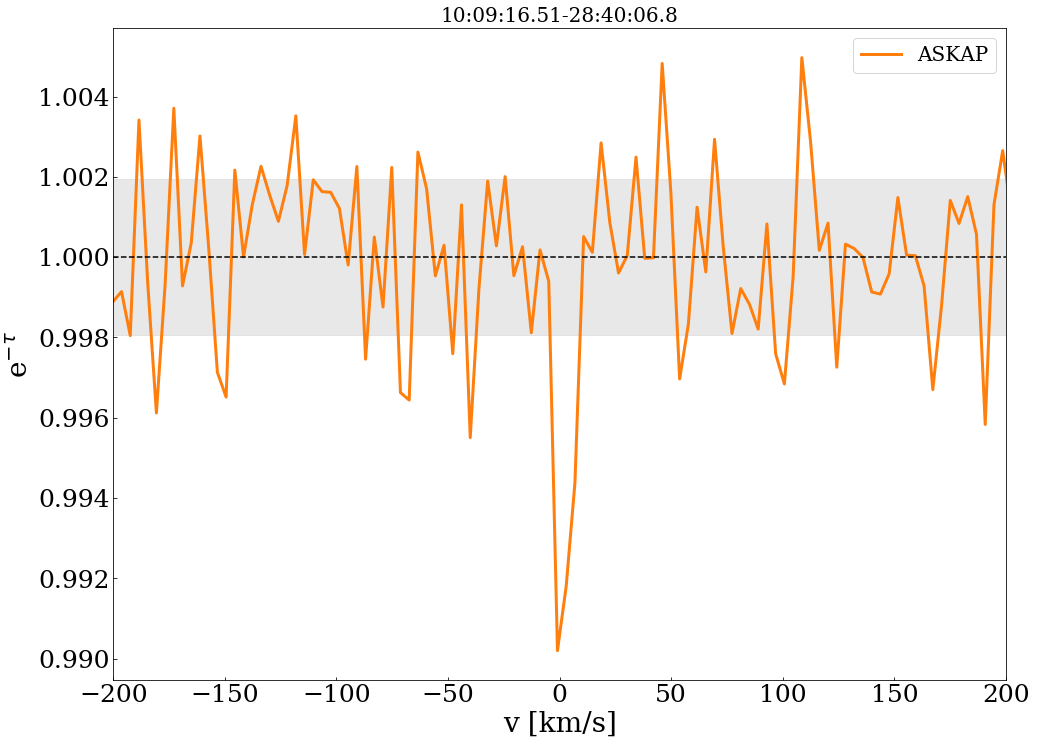

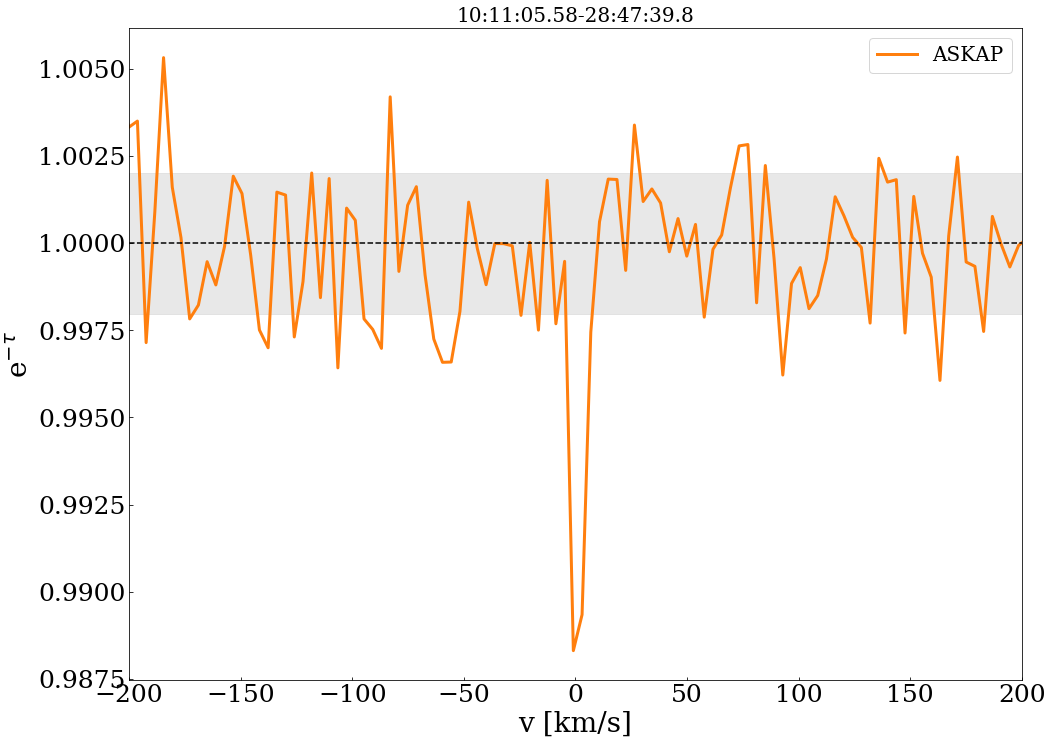

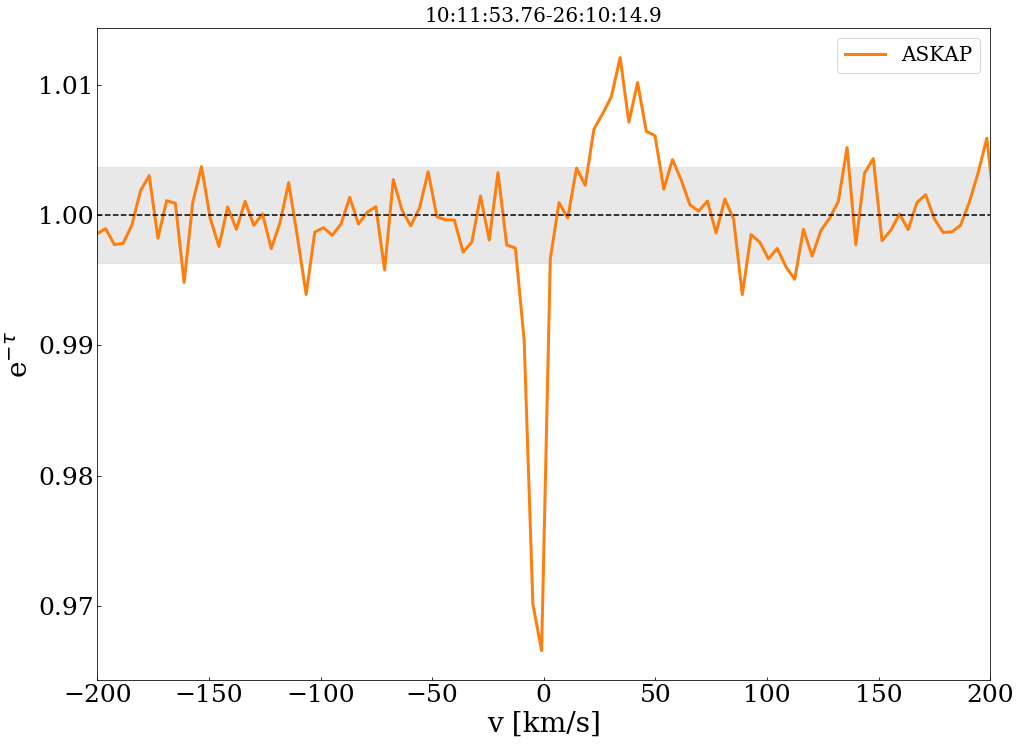

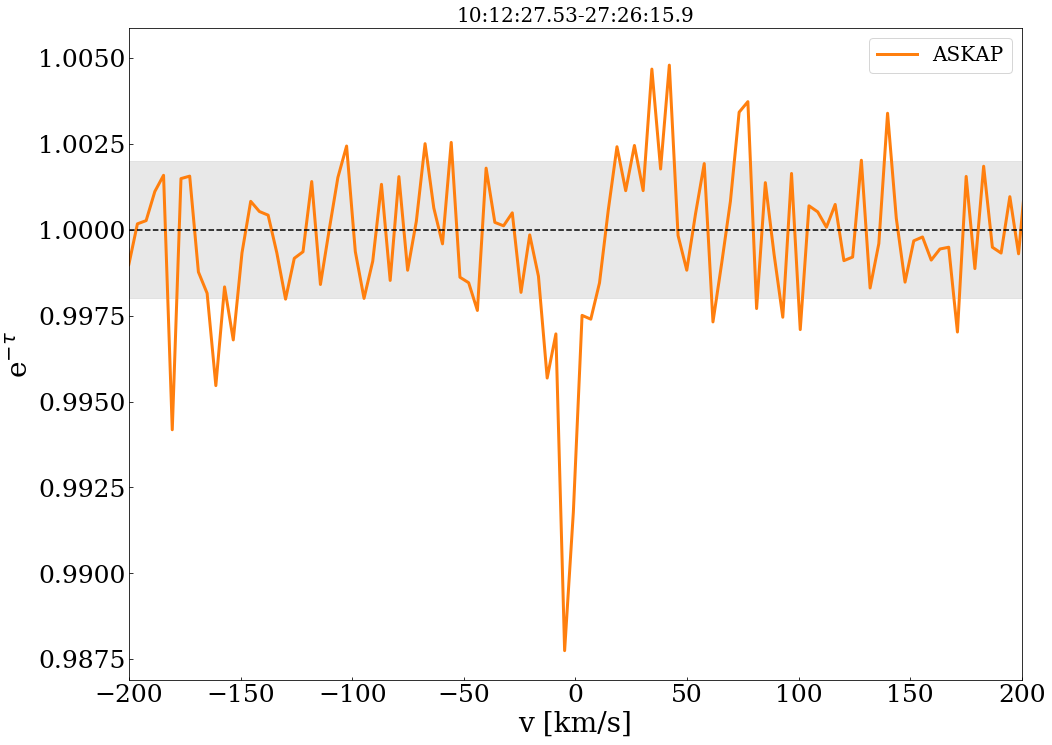

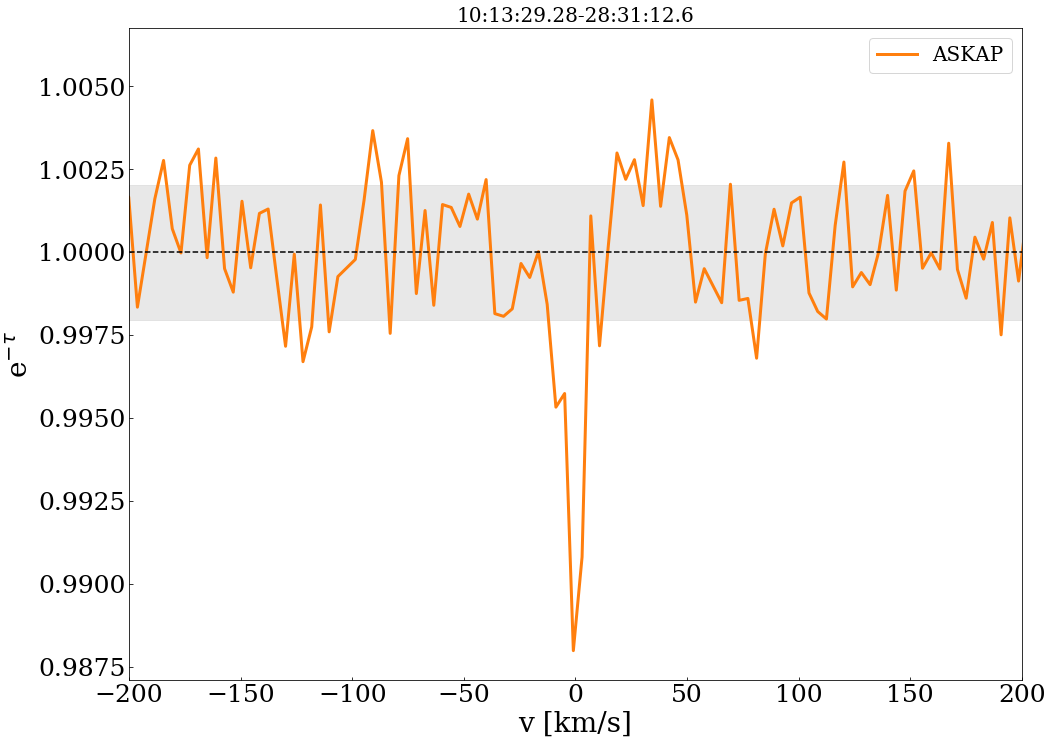

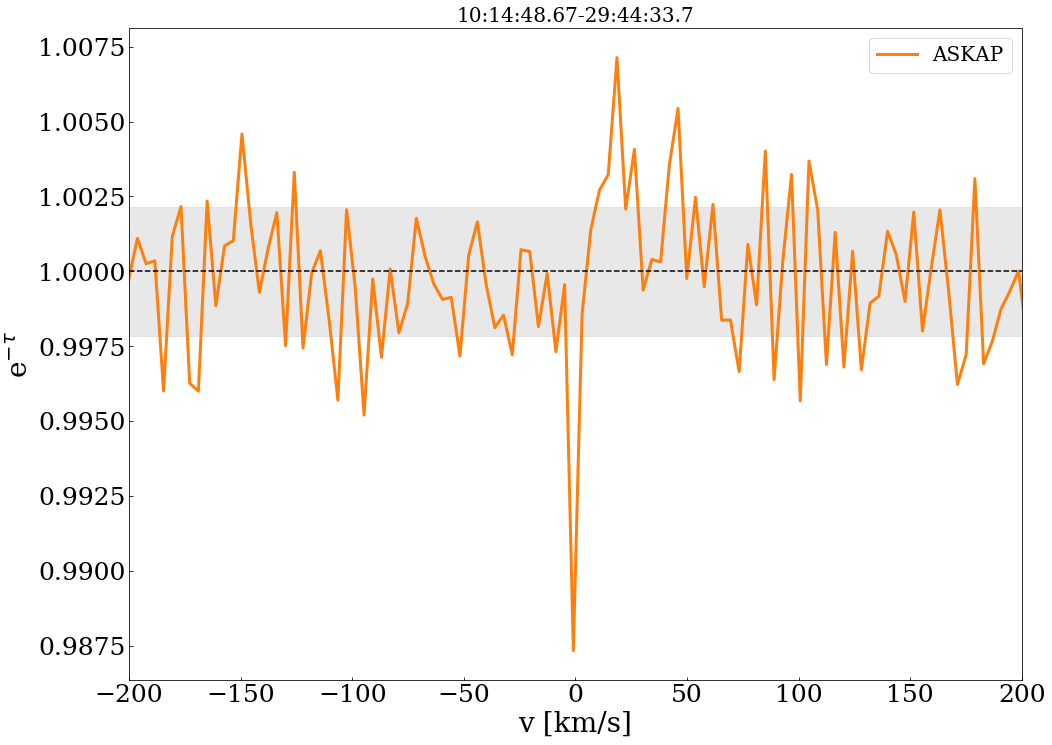

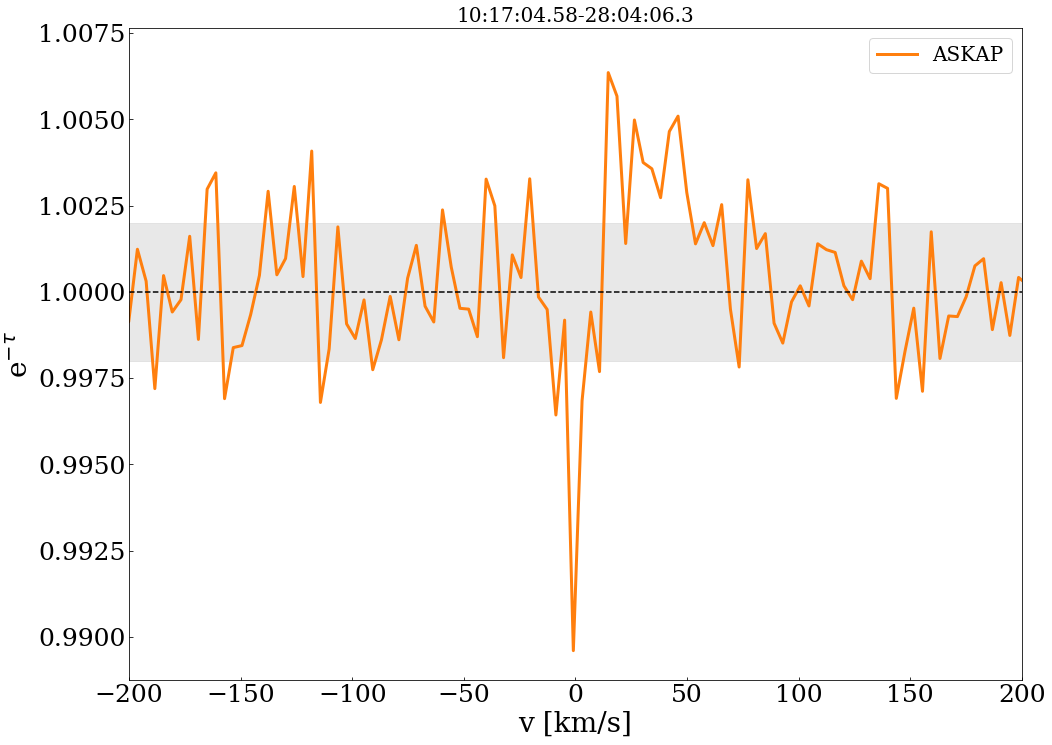

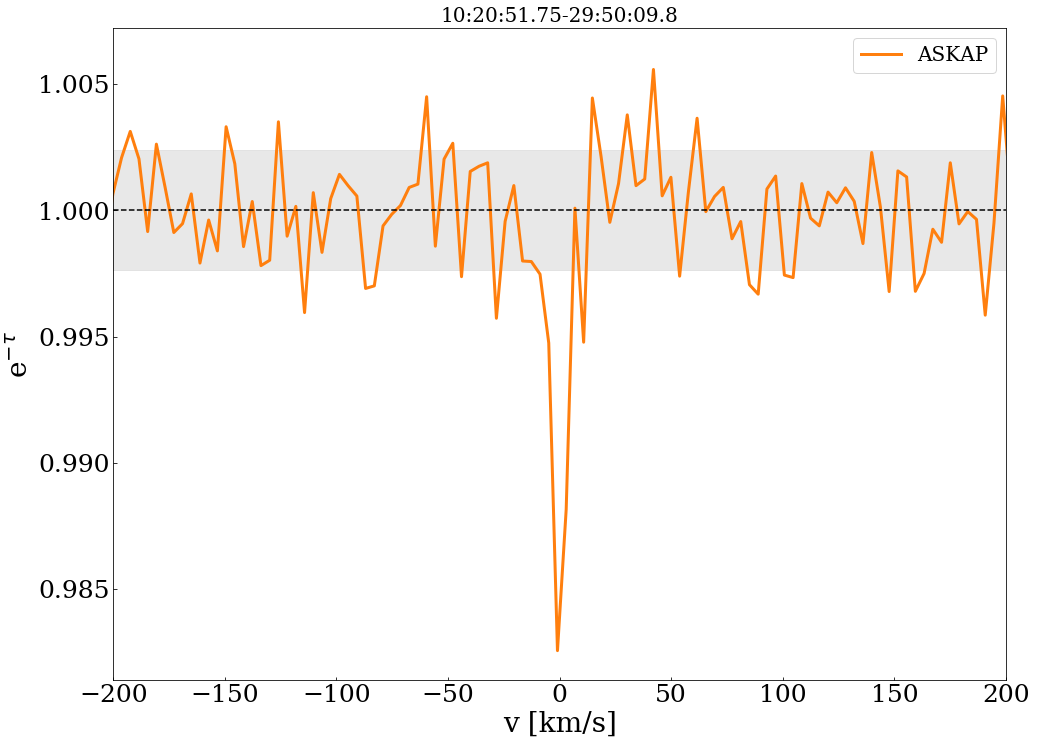

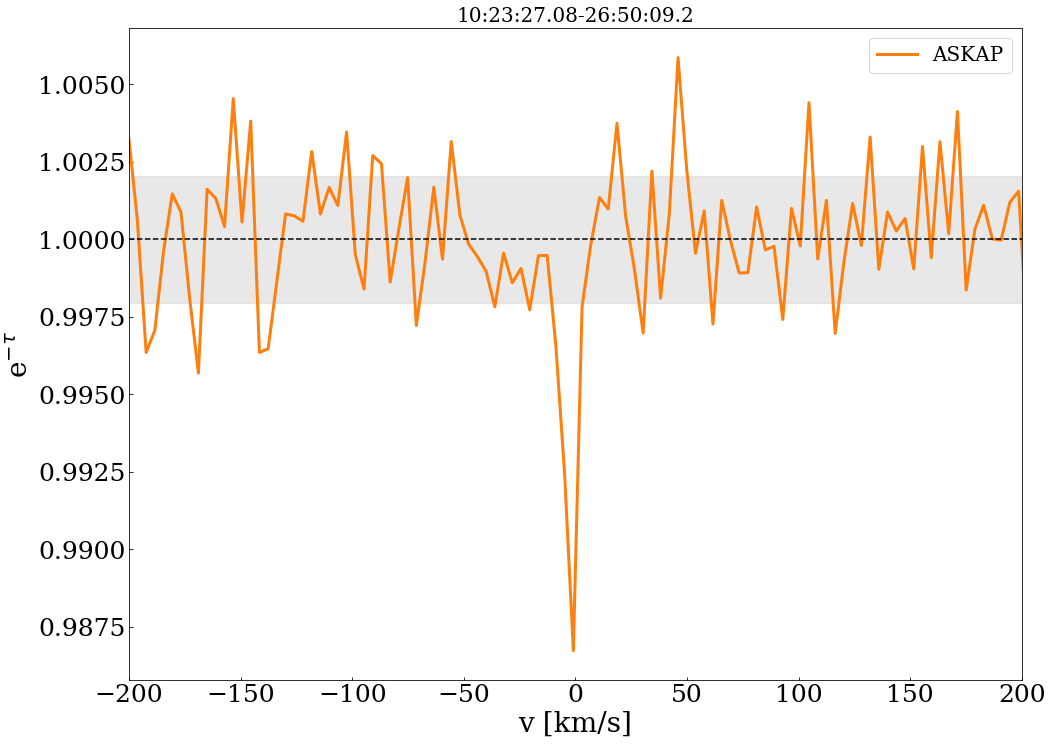

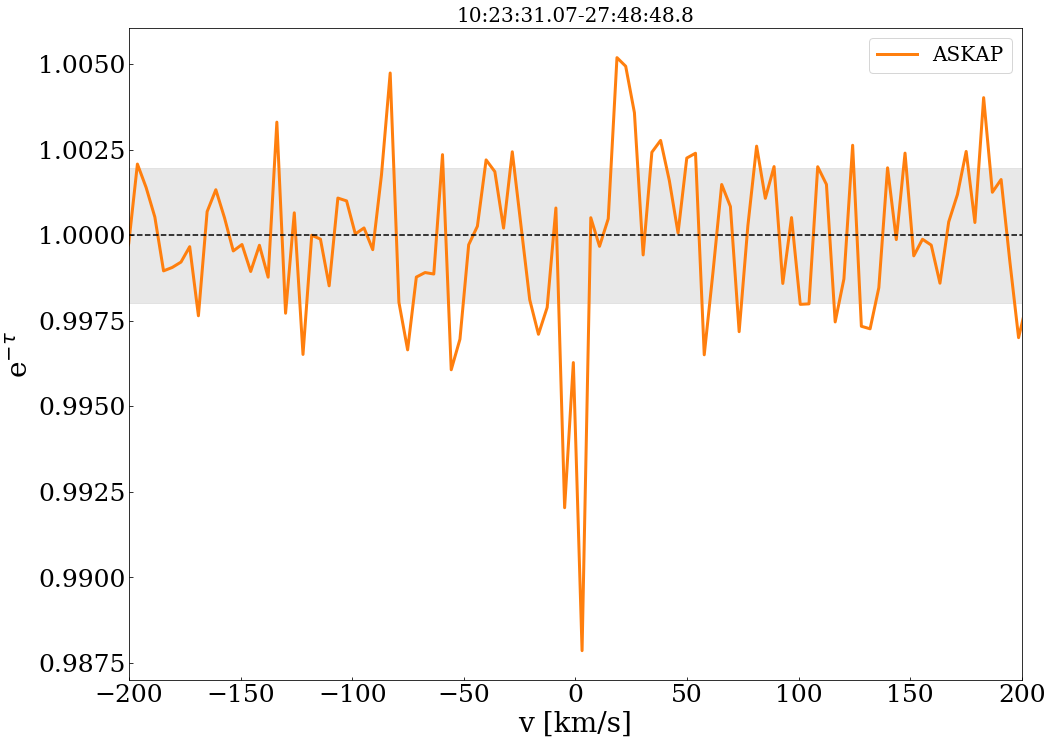

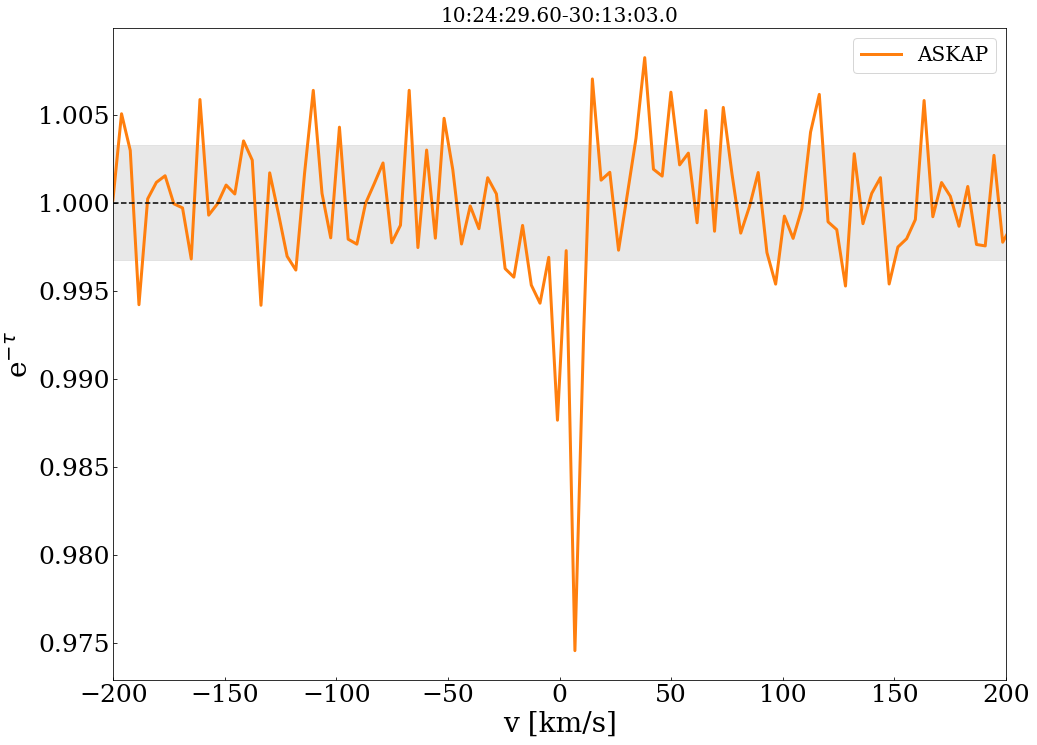

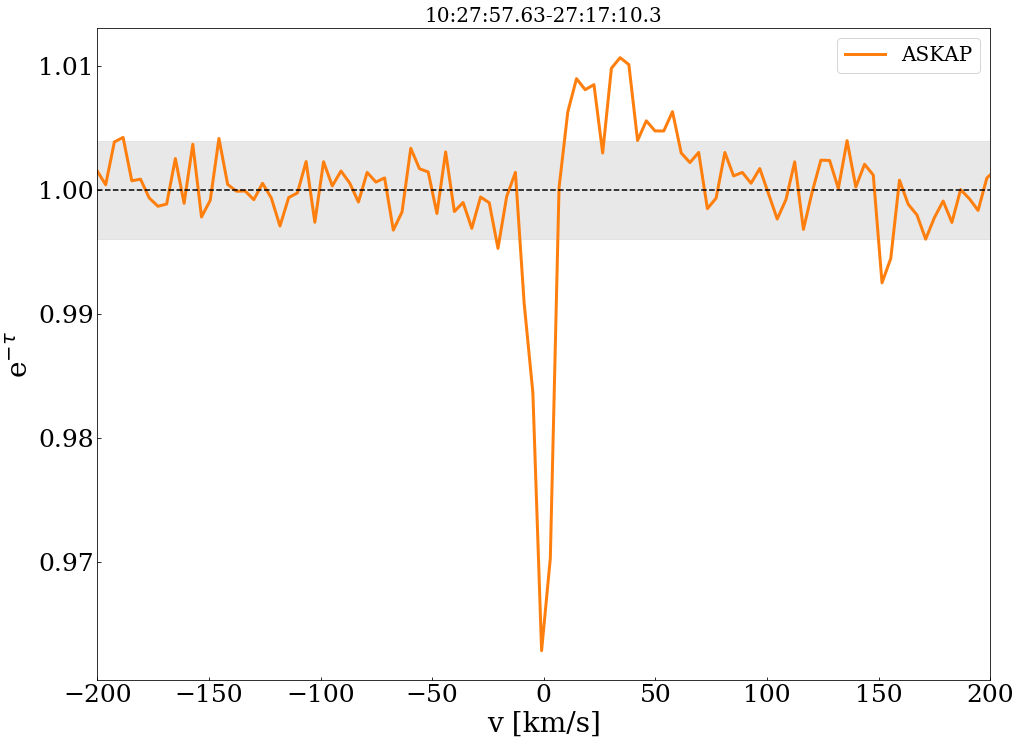

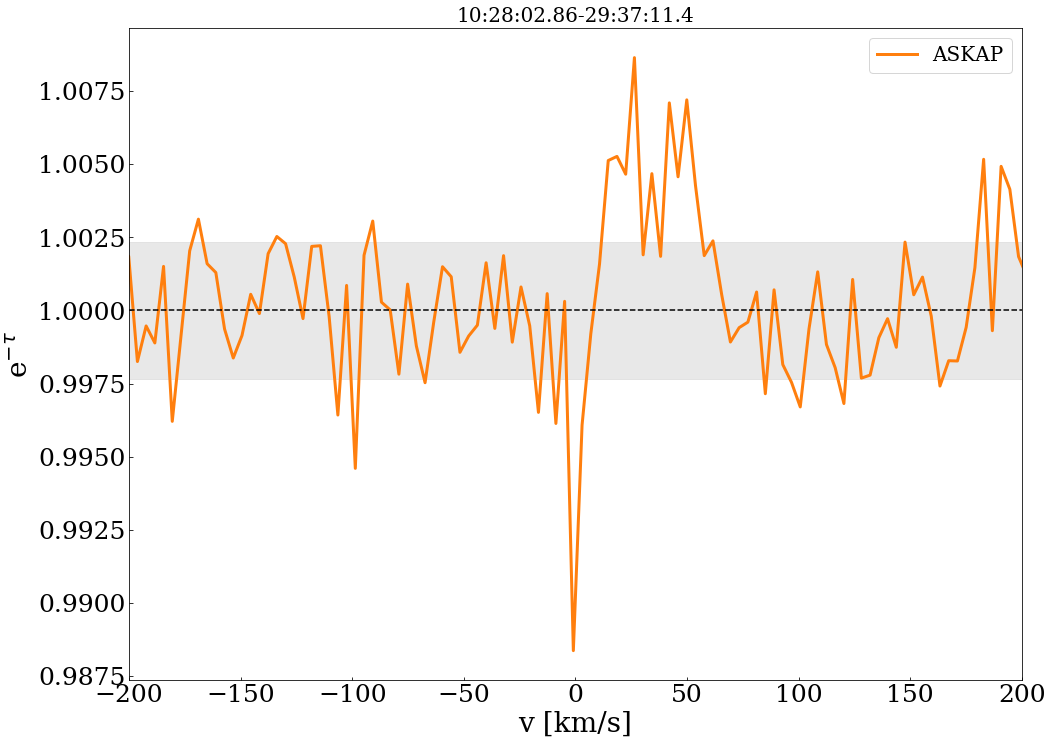

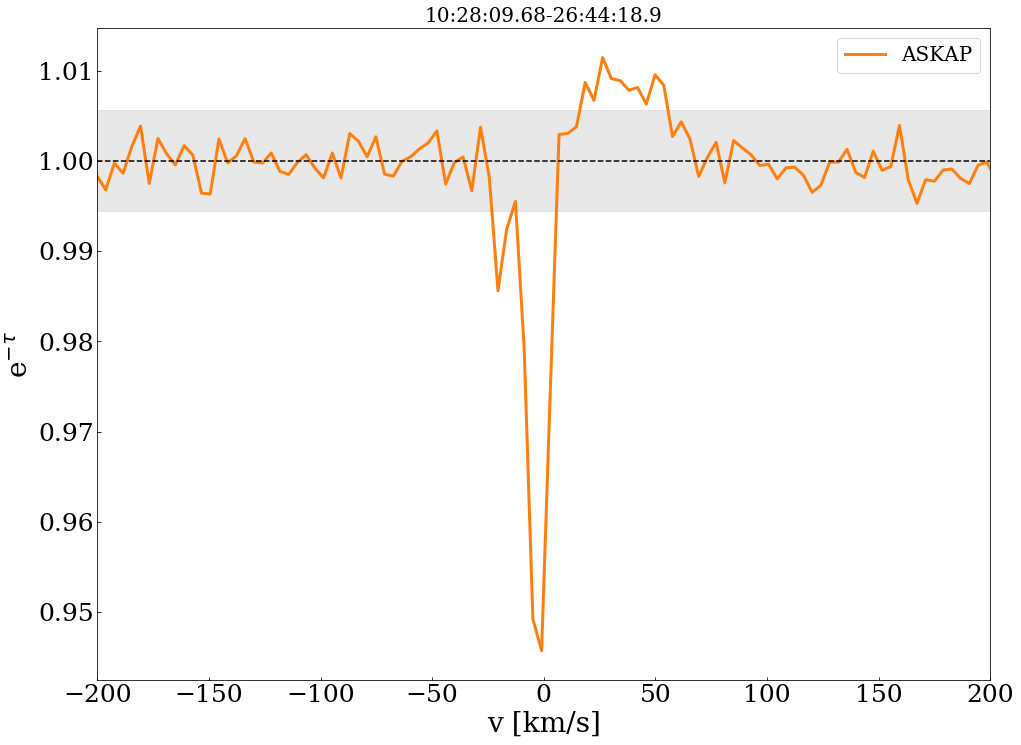

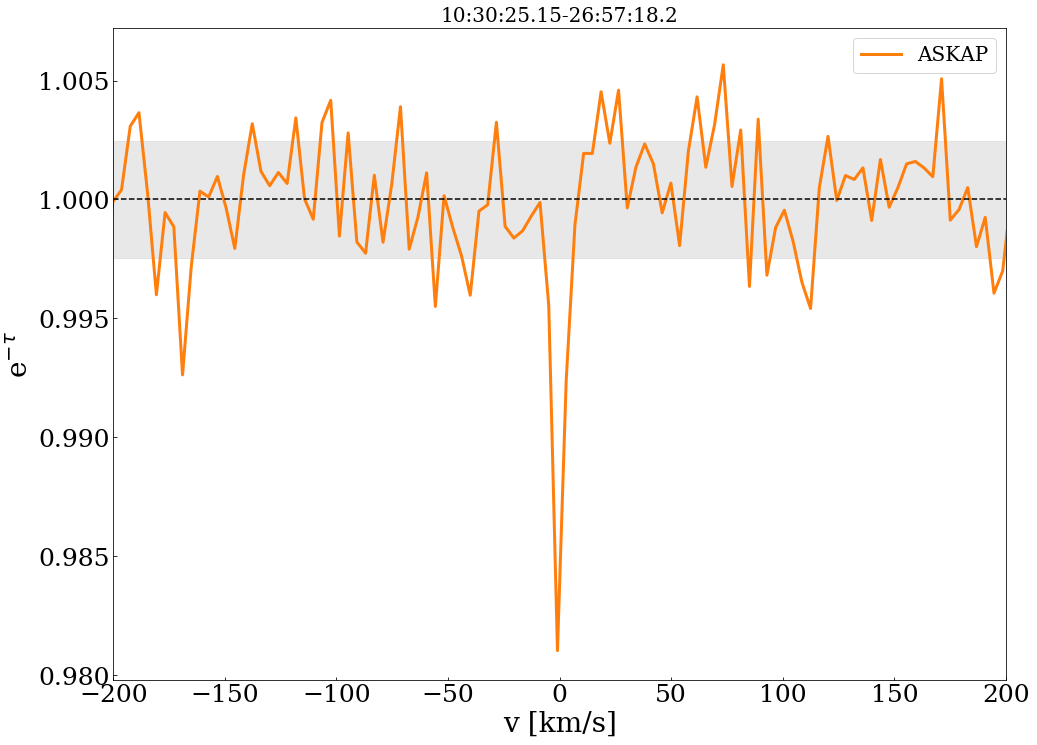

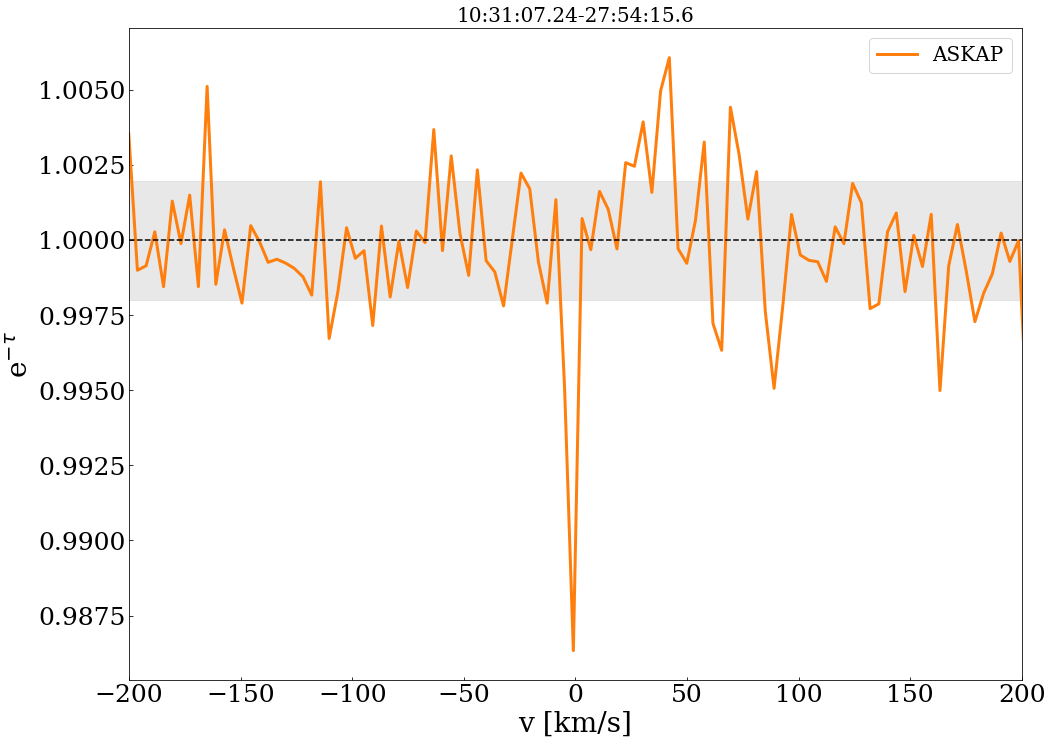

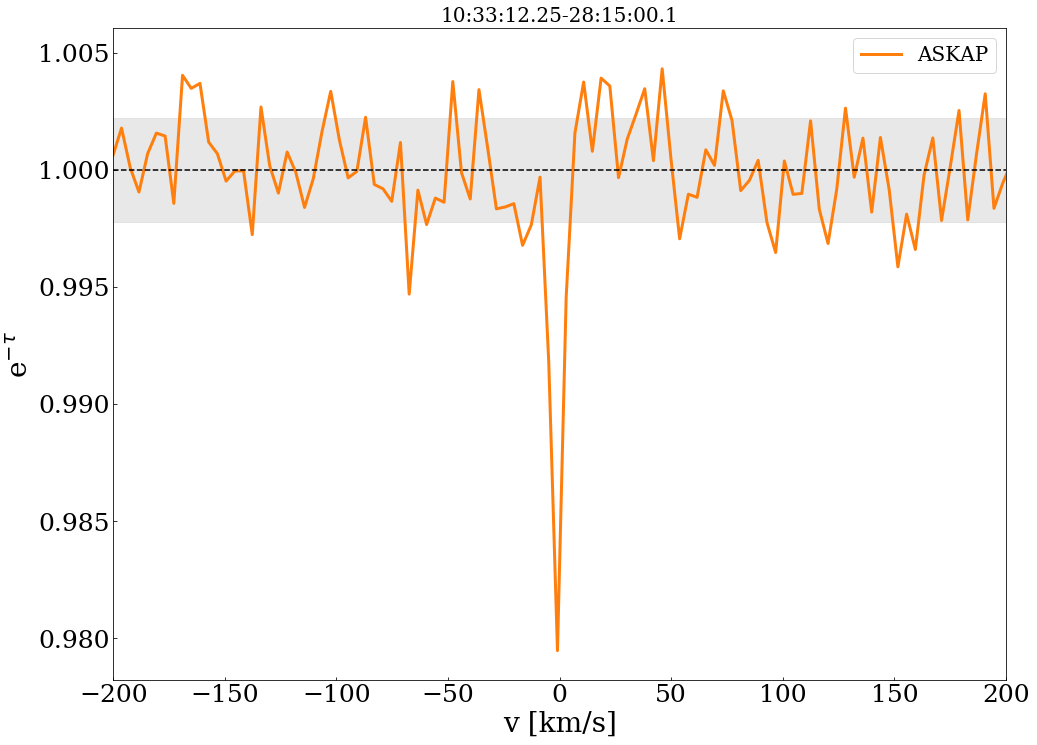

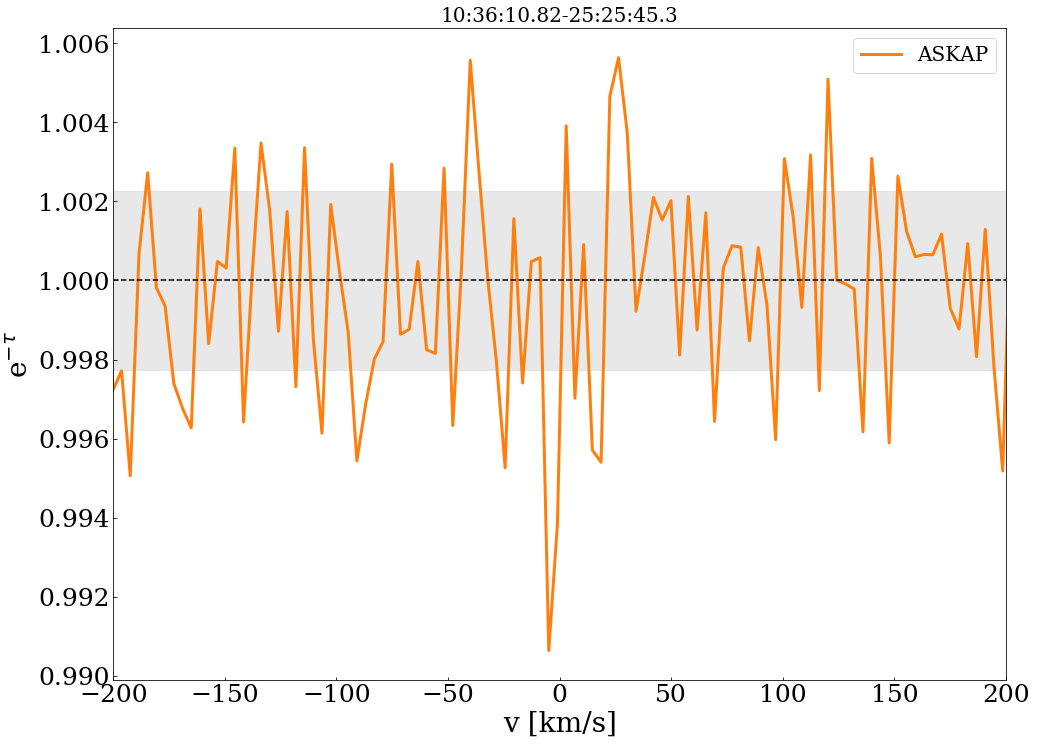

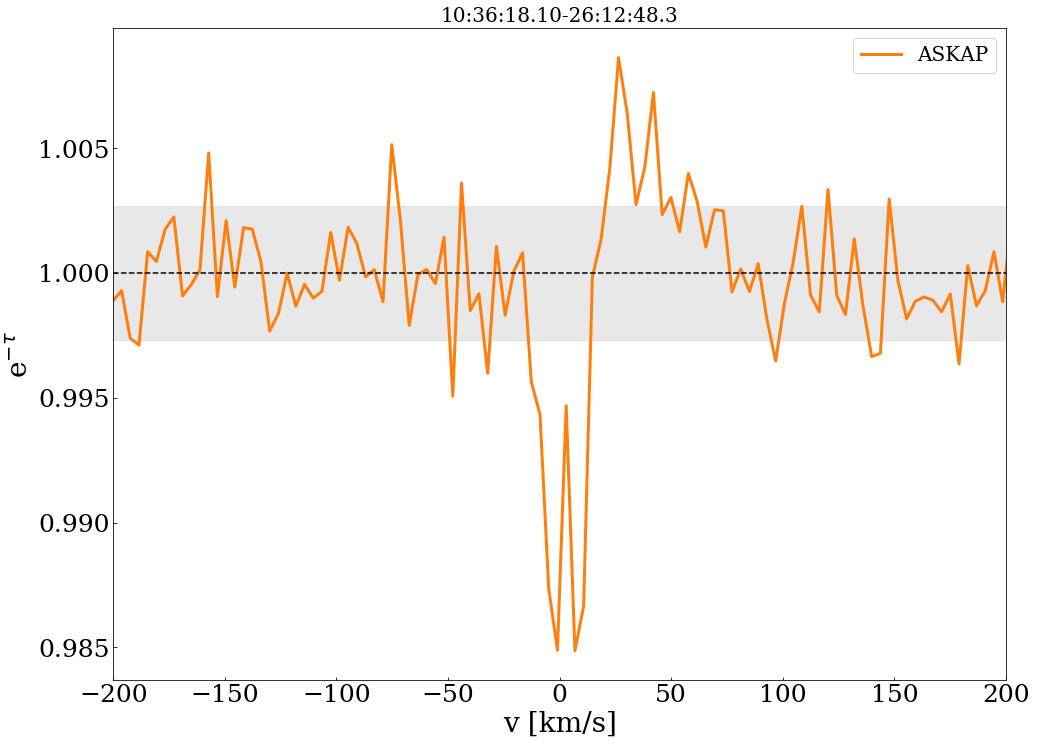

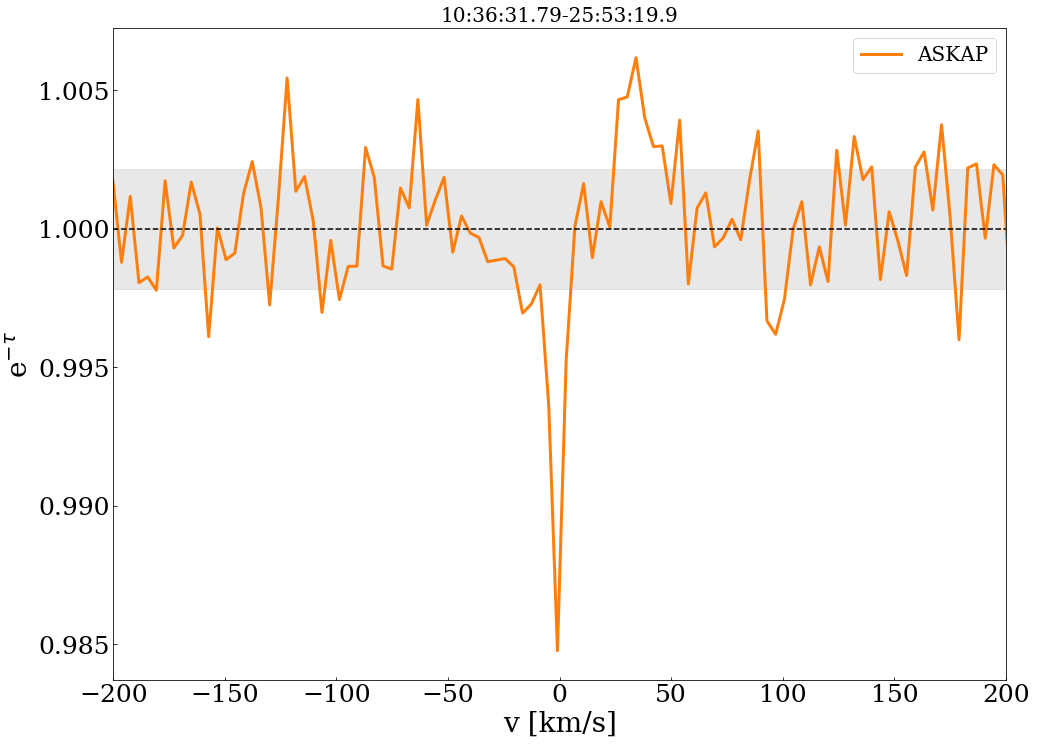

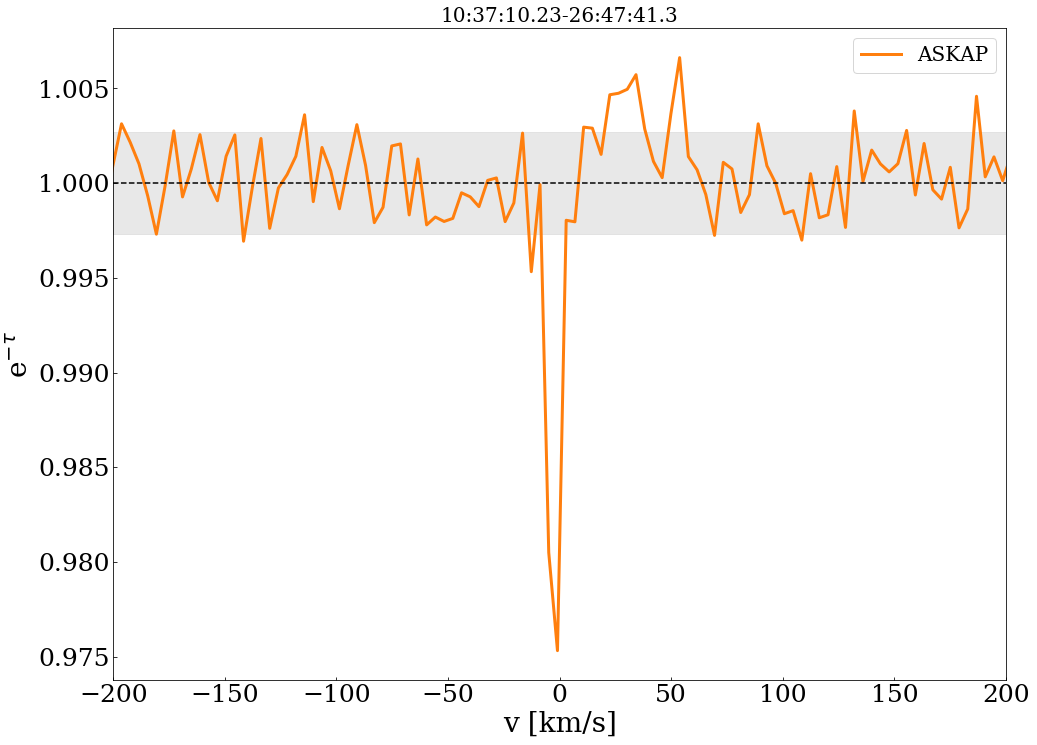

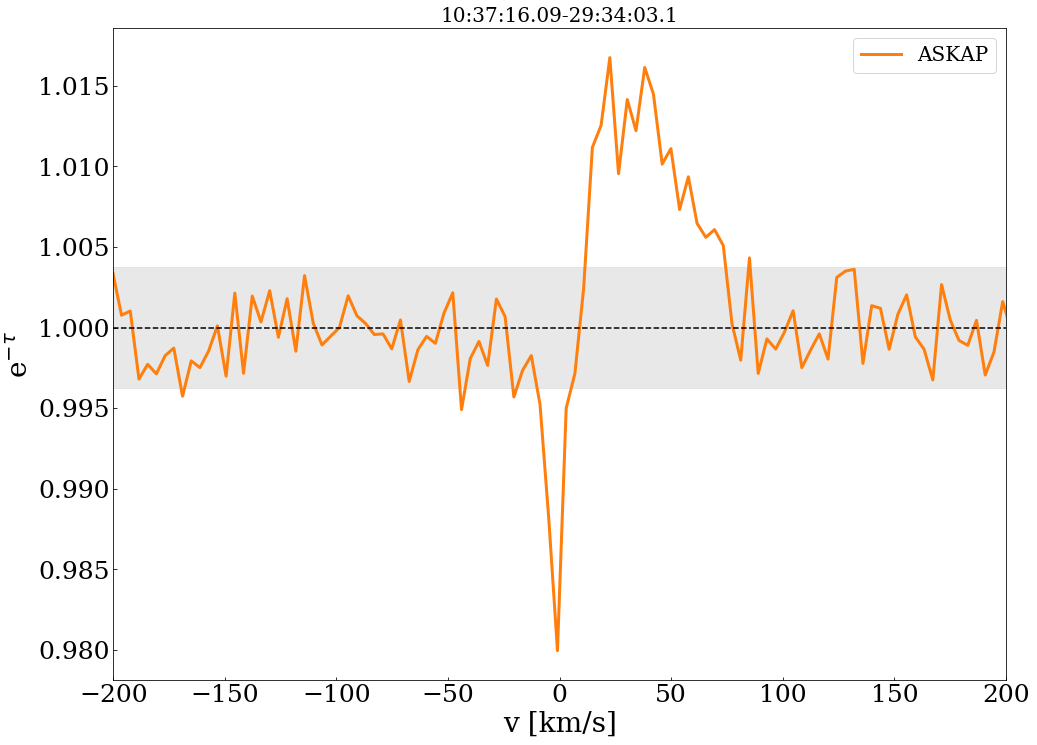

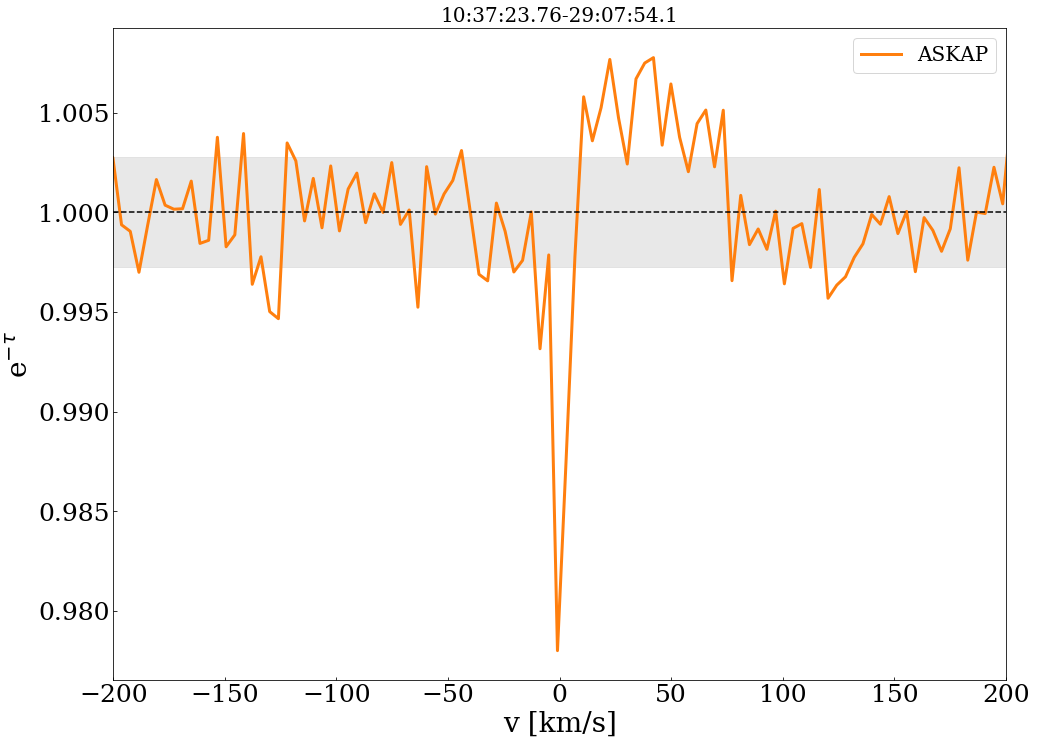

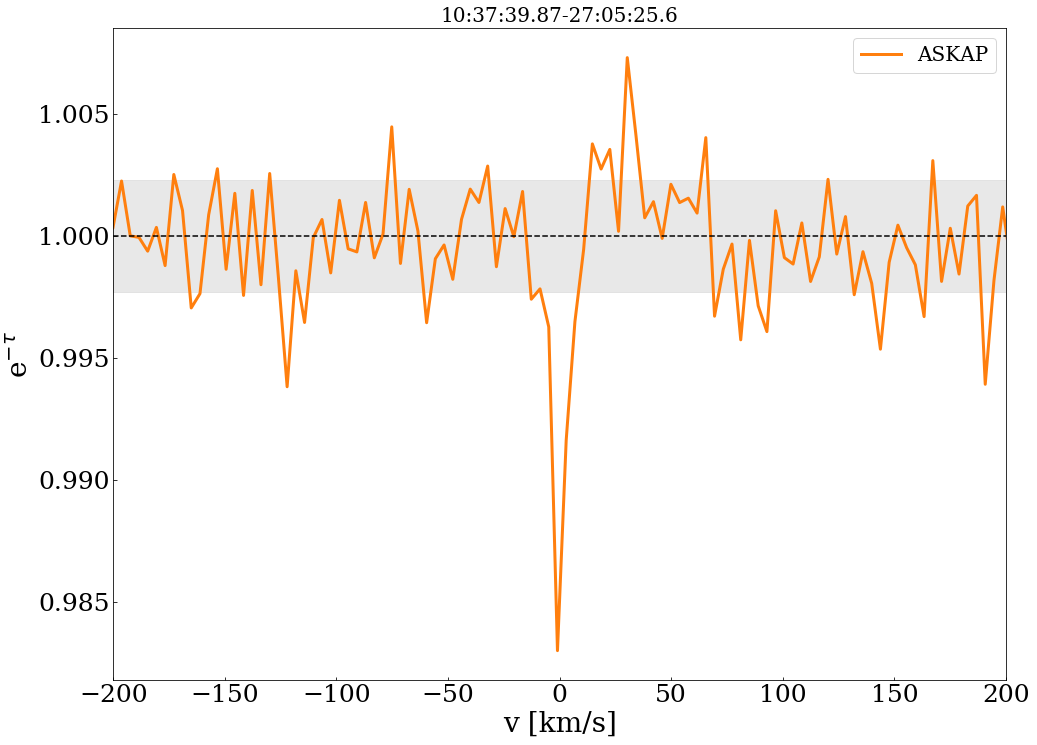

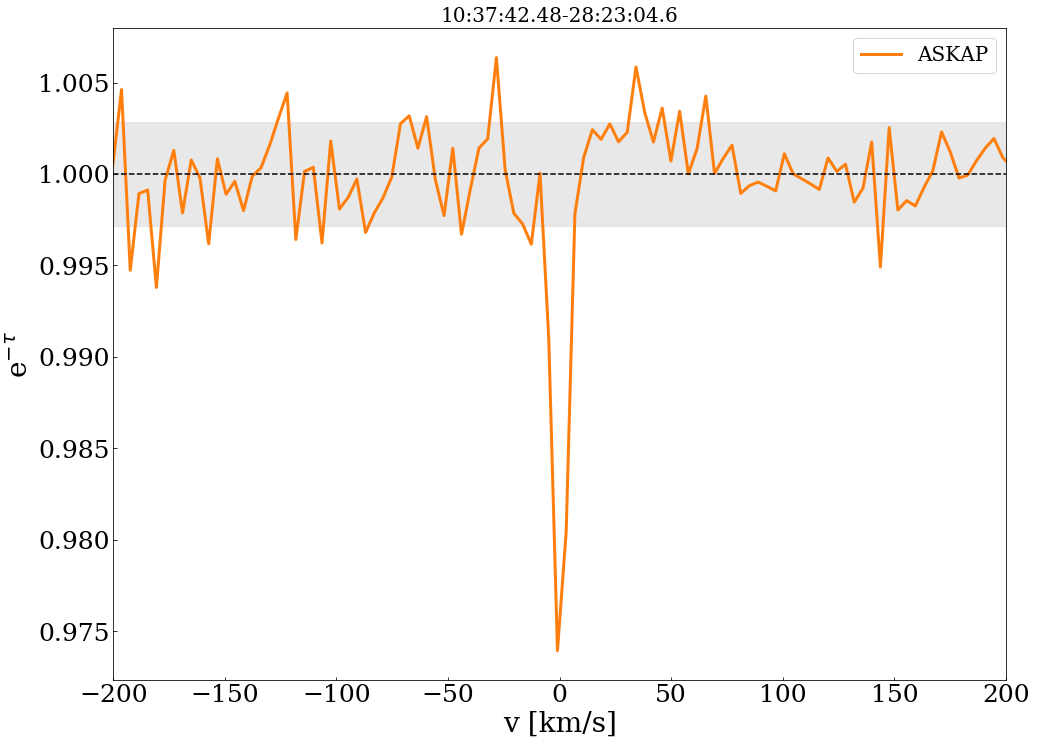

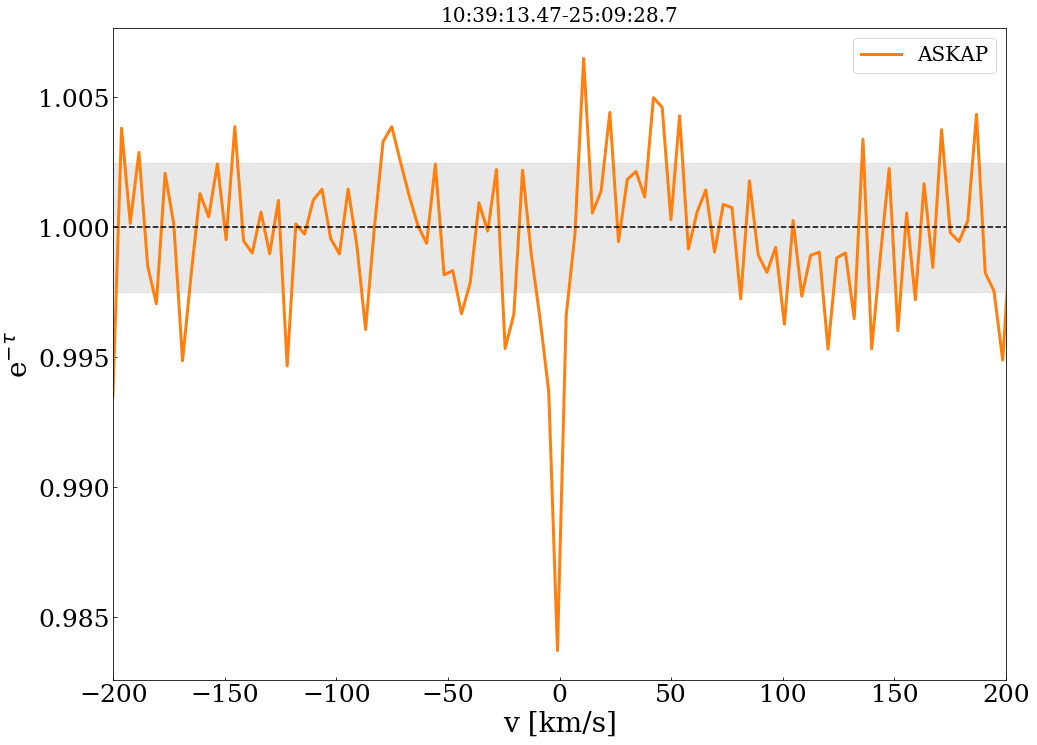

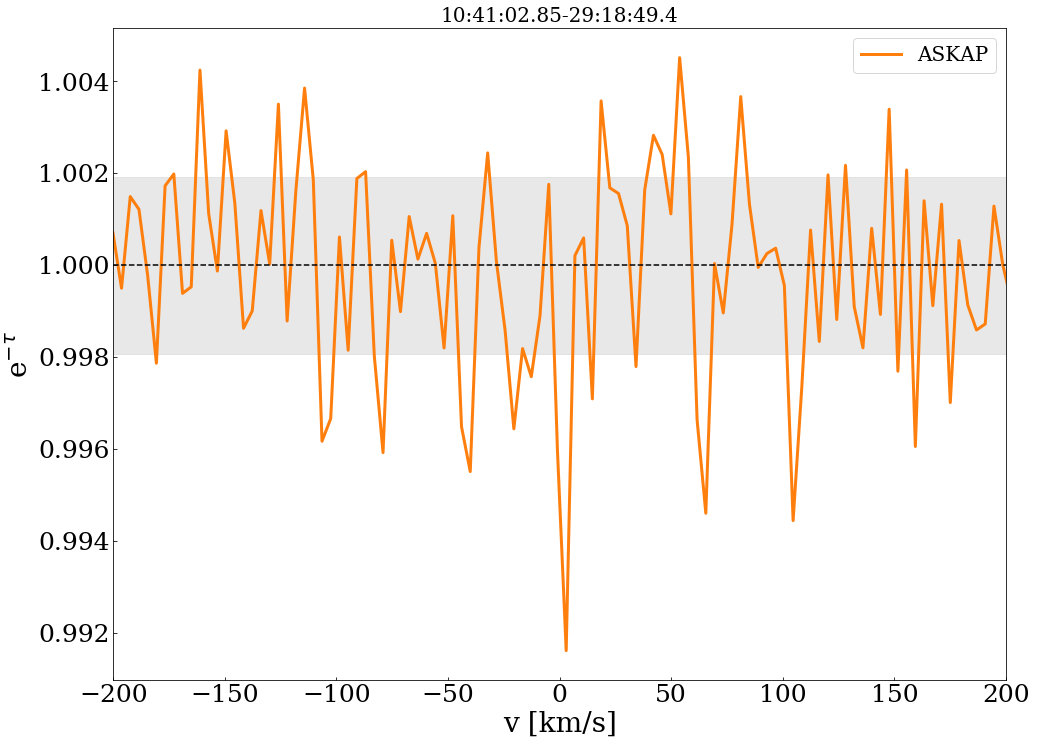

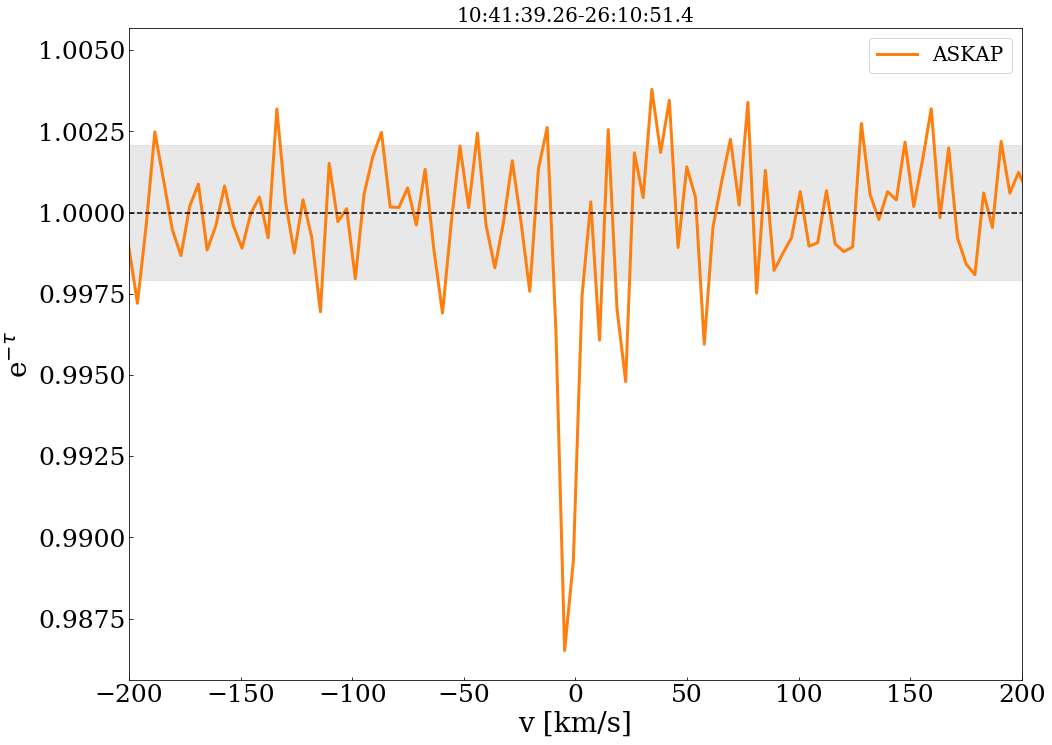

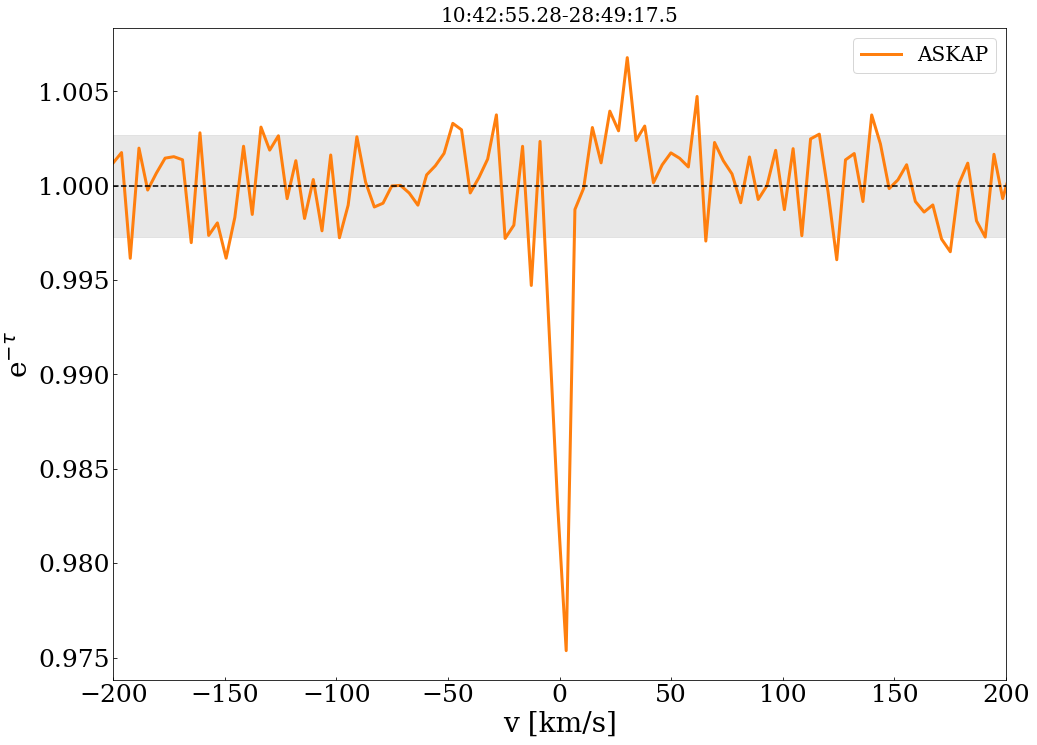

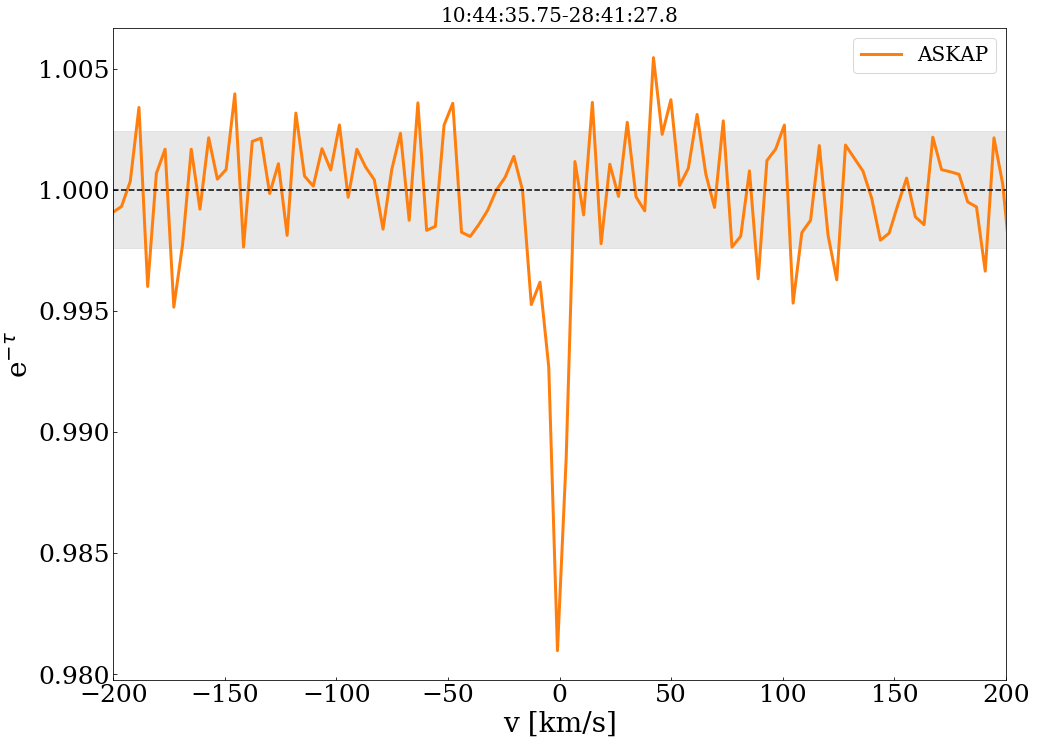

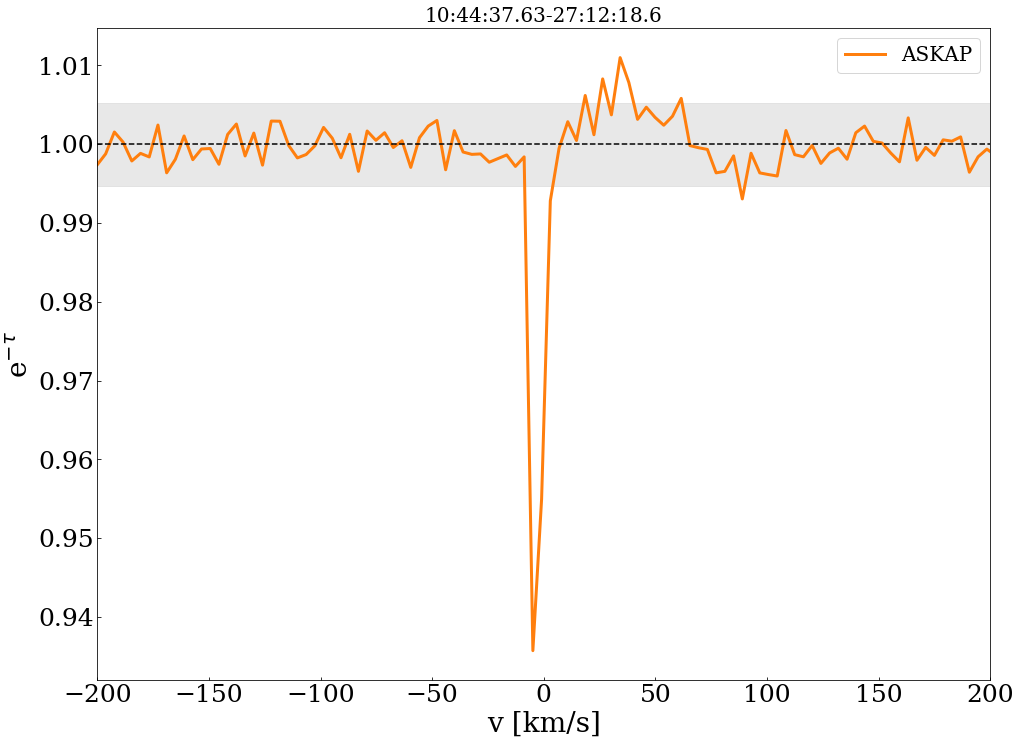

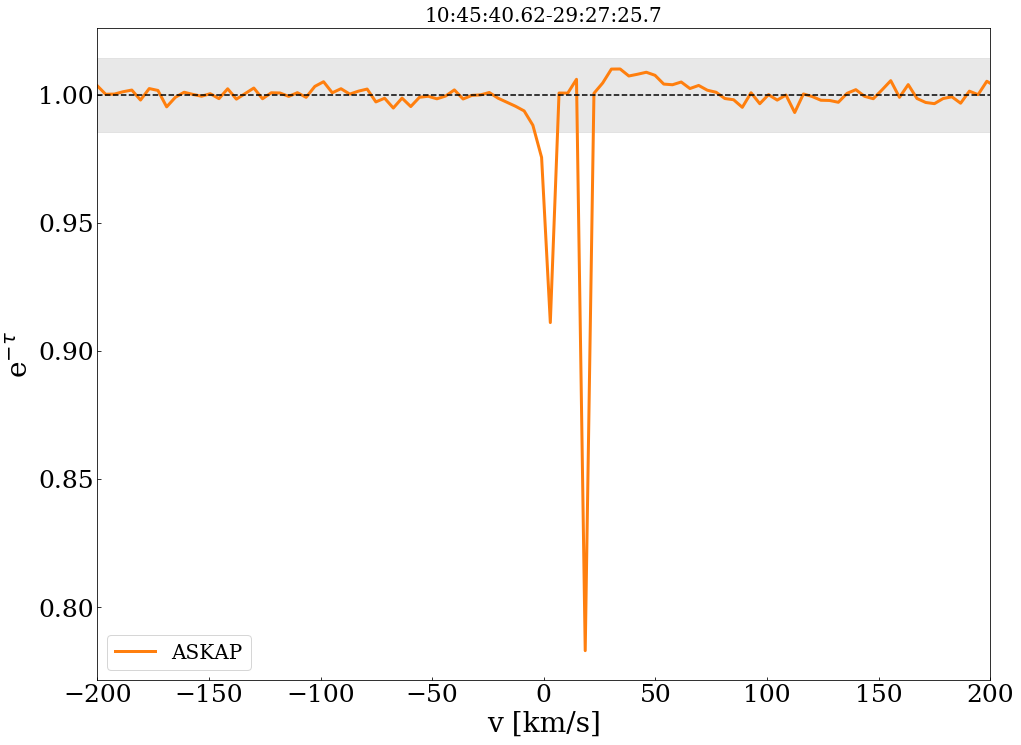

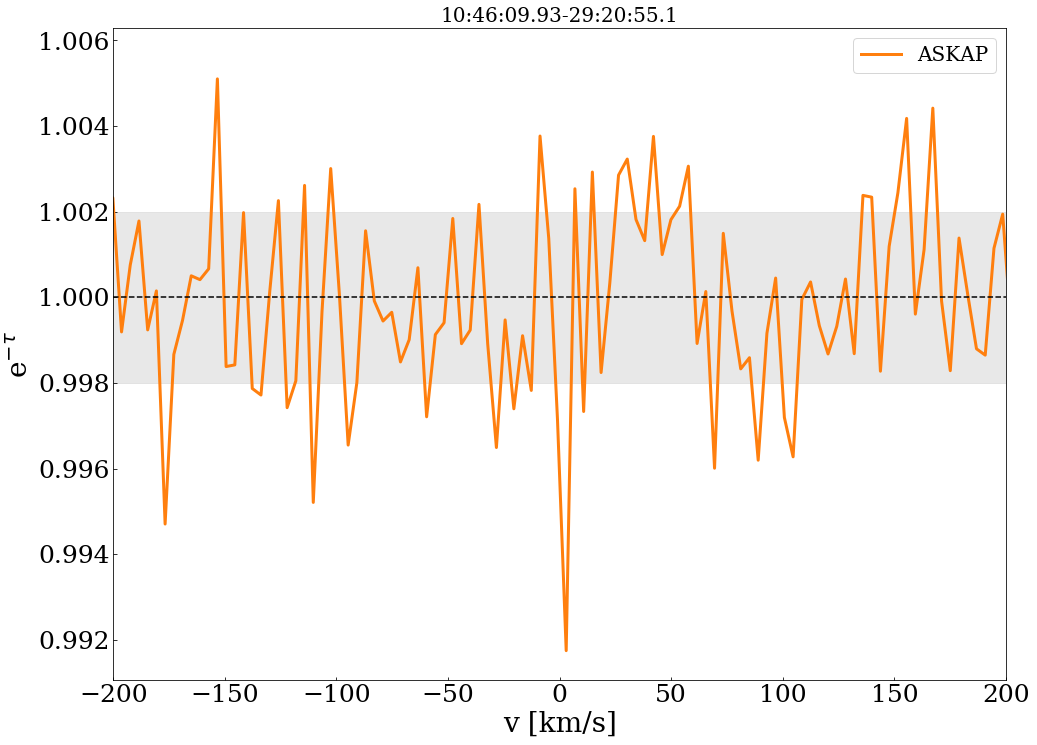

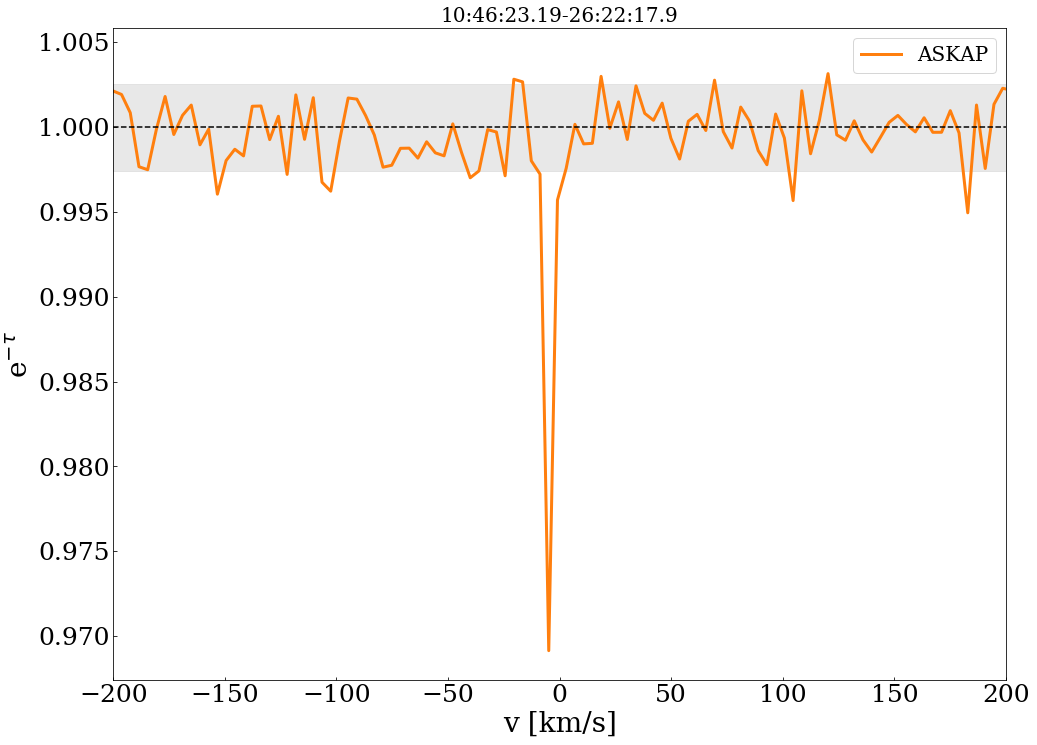

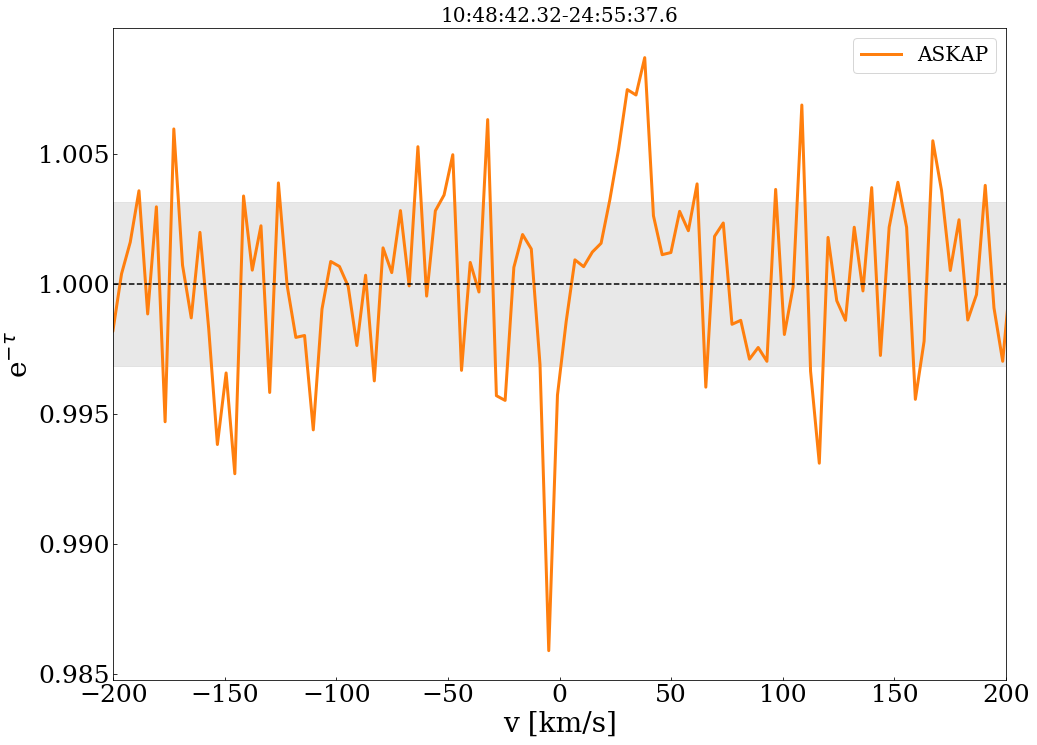

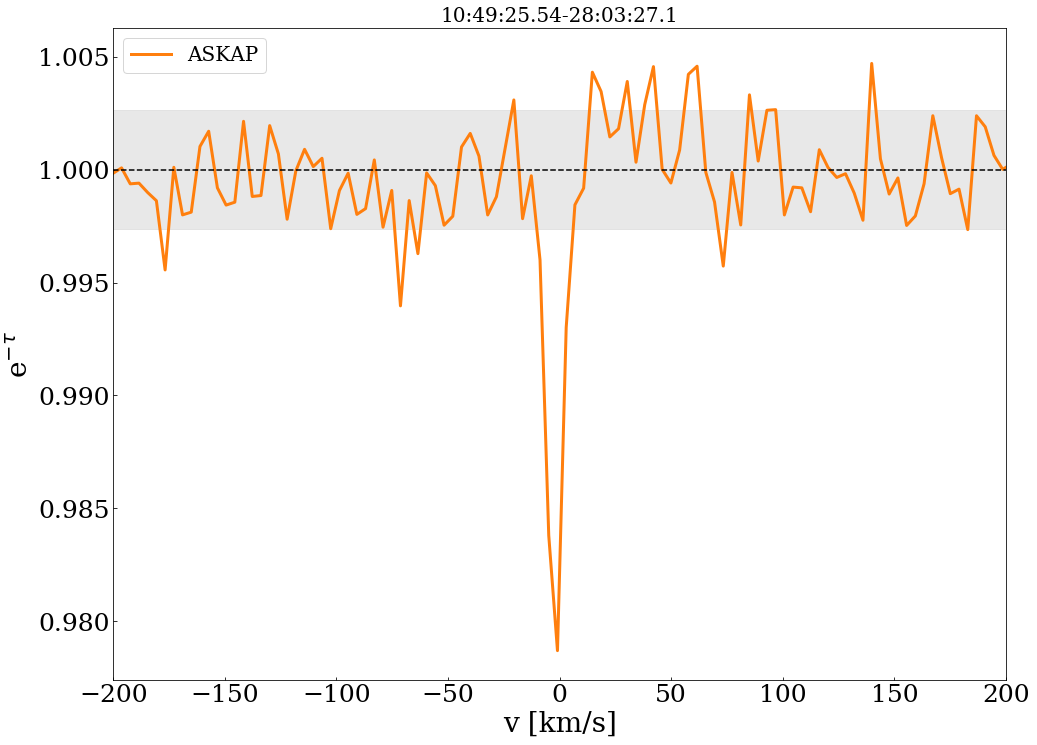

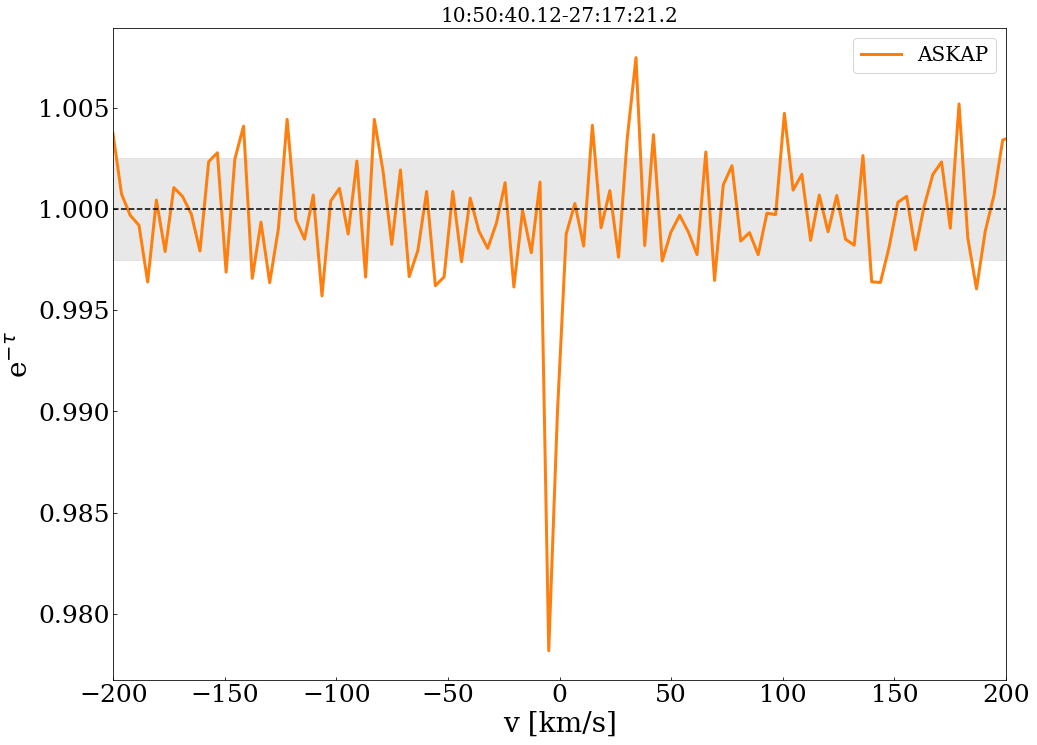

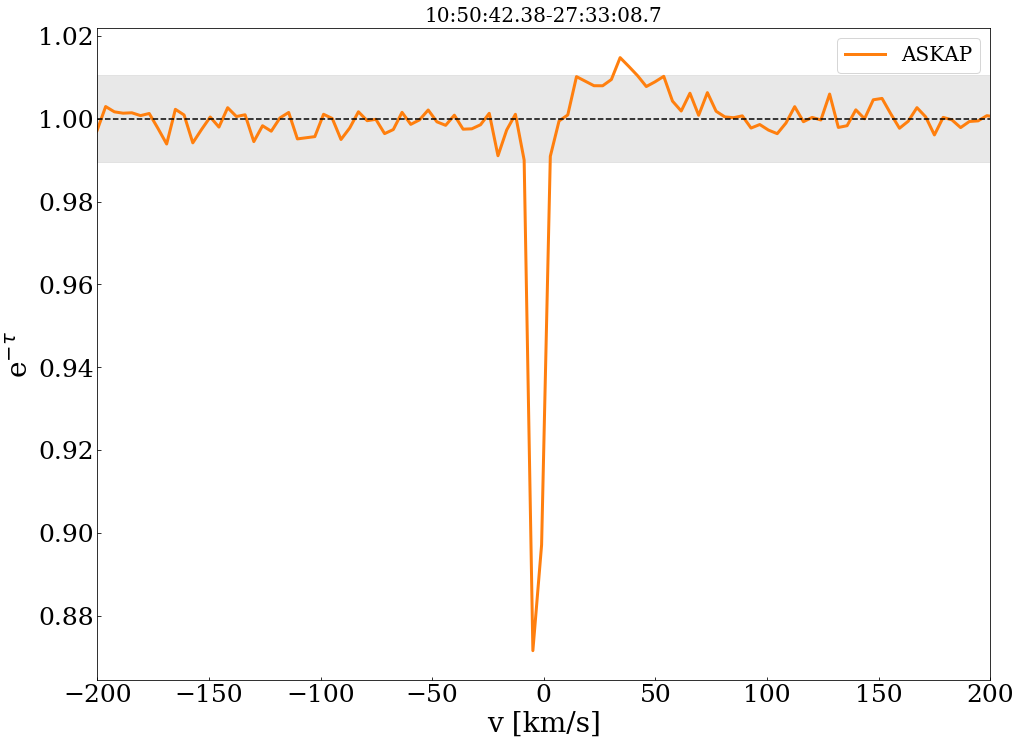

In [7]:
cube_askap = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/Karens_test_v2/Hydra_MW.fits')  # Open the FITS file for reading
askap = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/Karens_test_v2/Hydra_MW.fits')  # Open the FITS file for reading
d_askap = askap[0].data
h_askap = askap[0].header
w_askap = WCS(h_askap, askap)

MRO = EarthLocation.of_site('mro') 
barycorr = c.radial_velocity_correction(obstime=Time('2019-10-25'), location=MRO) 
restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (cube_askap.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) - barycorr/2

coordinate = '{}{}'.format(h_askap['CRVAL1'], h_askap['CRVAL2'])
c = SkyCoord(coordinate, unit=(u.deg, u.deg))
print(c)

result = Vizier(column_filters={"S1.4":">150"}, row_limit=-1).query_constraints(catalog='VIII/65/nvss',RAJ2000='>{} & <{}'.format(c.ra.deg-3.6, c.ra.deg+9.4), DEJ2000='>{} & <{}'.format(c.dec.deg-3, c.dec.deg+3))
print('number of sources:',len(result[0]))
#print(result[0]['RAJ2000'][0],result[0]['DEJ2000'][0])

detection = []

for i in range(len(result[0])):
    coord = '{} {}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':'))
    c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    pixels_askap = c2.to_pixel(w_askap)
    #print(coord )
    #print(pixels_askap)

    spectrum_askap = cube_askap[:, int(pixels_askap[1]), int(pixels_askap[0])]  # 10:09:10 -28:55:57
    tau_askap = np.log(spectrum_askap.value +1) * -1.
    rms = np.sqrt(np.mean(spectrum_askap.value**2))
    
    if abs(np.min(spectrum_askap.value)) > rms*4:
        detection.append(i)

        # plot
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111)
        ax.set_title('{}{}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':')), fontsize=20)

        plt.plot(vel_askap, spectrum_askap.value+1, 'C1', linewidth=3, label='ASKAP')
        ax.axhspan(1-rms, 1+rms, alpha=0.5, color='lightgrey')
        #plt.title('102809-264418', fontsize=30)
        plt.ylabel(r'e$^{-\tau}$', fontsize=28)
        plt.xlabel("v [km/s]", fontsize=28)
        plt.xlim(-200,200)
        #plt.ylim(0.92,1.02)
        plt.axhline(1, color='k', linestyle='--')
        plt.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=25)
        fig.savefig('./spectra_plots/{}{}_ASKAP_spectra.png'.format(result[0]['RAJ2000'][i].replace(' ',''),result[0]['DEJ2000'][i].replace(' ','')))

print('4 sigma detections:', len(detection))    

<SkyCoord (ICRS): (ra, dec) in deg
    (153.94930833, -27.37438056)>
number of sources: 93


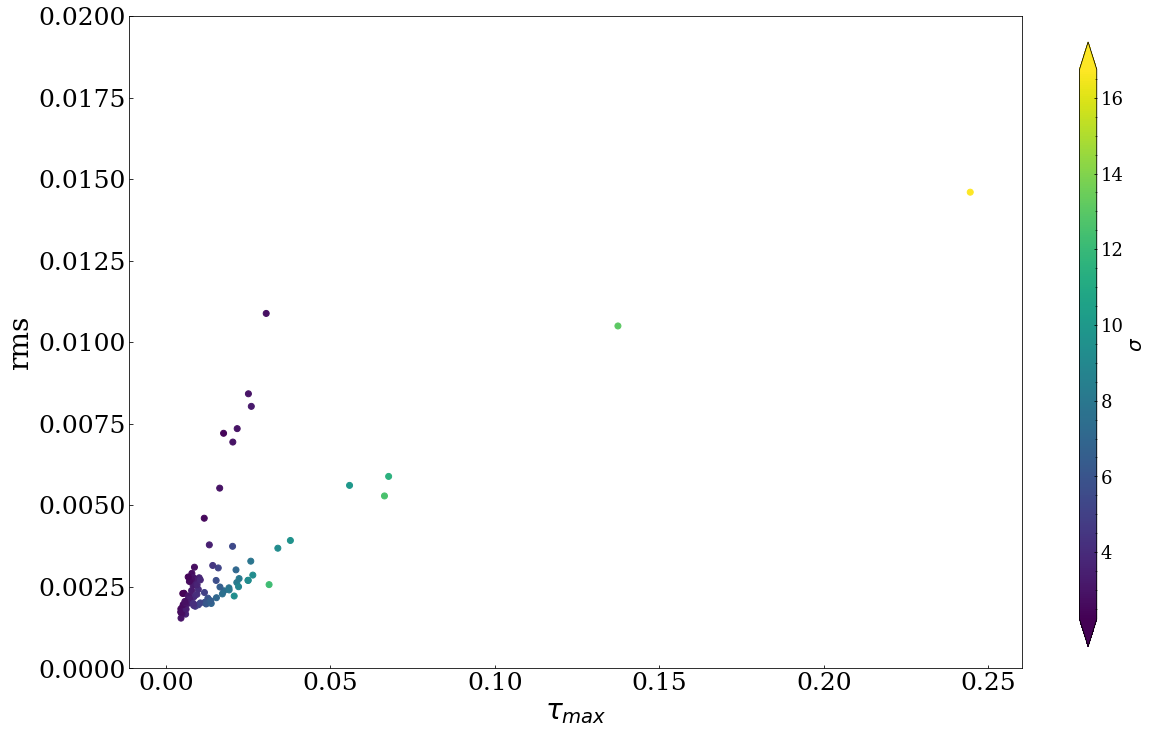

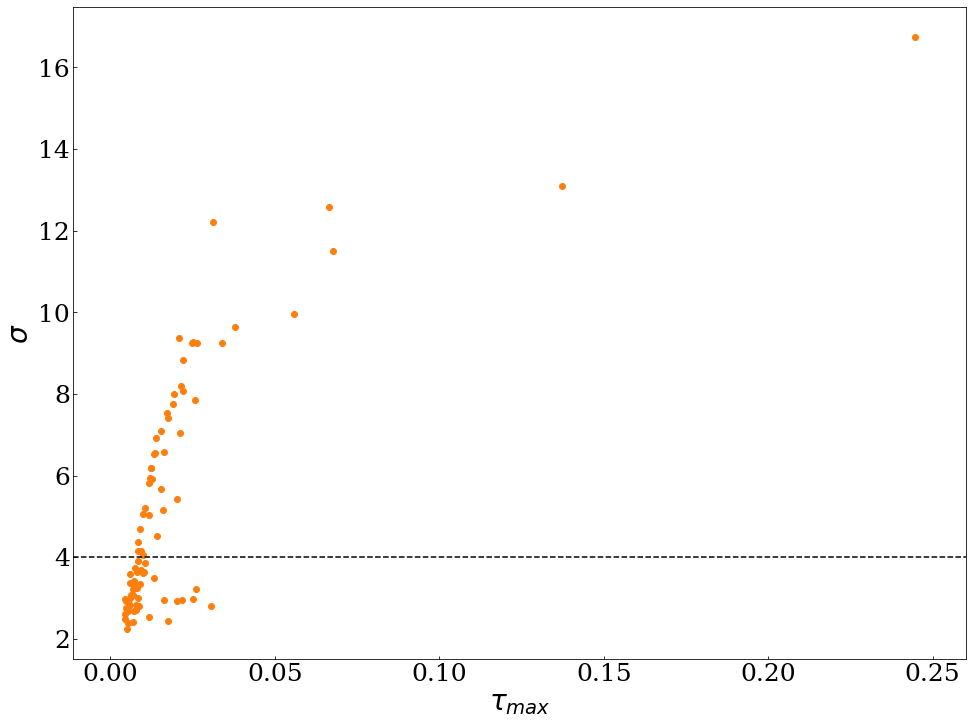

In [28]:
cube_askap = SpectralCube.read('/Users/denes/Research/high_lat_HI/ASKAP_data/Karens_test_v2/Hydra_MW.fits')  # Open the FITS file for reading
askap = fits.open('/Users/denes/Research/high_lat_HI/ASKAP_data/Karens_test_v2/Hydra_MW.fits')  # Open the FITS file for reading
d_askap = askap[0].data
h_askap = askap[0].header
w_askap = WCS(h_askap, askap)

MRO = EarthLocation.of_site('mro') 
barycorr = c.radial_velocity_correction(obstime=Time('2019-10-25'), location=MRO) 
restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (cube_askap.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) - barycorr/2

coordinate = '{}{}'.format(h_askap['CRVAL1'], h_askap['CRVAL2'])
c = SkyCoord(coordinate, unit=(u.deg, u.deg))
print(c)

result = Vizier(column_filters={"S1.4":">150"}, row_limit=-1).query_constraints(catalog='VIII/65/nvss',RAJ2000='>{} & <{}'.format(c.ra.deg-3.6, c.ra.deg+9.4), DEJ2000='>{} & <{}'.format(c.dec.deg-3, c.dec.deg+3))
print('number of sources:',len(result[0]))
#print(result[0]['RAJ2000'][0],result[0]['DEJ2000'][0])

detection = []
max_tau = []
rms = []
sigma = []


for i in range(len(result[0])):
    coord = '{} {}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':'))
    c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    pixels_askap = c2.to_pixel(w_askap)
    #print(coord )
    #print(pixels_askap)

    spectrum_askap = cube_askap[:, int(pixels_askap[1]), int(pixels_askap[0])]  # 10:09:10 -28:55:57
    tau_askap = np.log(spectrum_askap.value +1) * -1.
    rms.append(np.sqrt(np.mean(spectrum_askap.value**2)))
    max_tau.append(np.max(tau_askap))
    sigma.append(np.max(tau_askap)/(np.sqrt(np.mean(spectrum_askap.value**2))))
    
    #if abs(np.min(spectrum_askap.value)) > rms*4:
        #detection.append(i)


        
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
#ax.set_title('{}{}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':')), fontsize=20)
cb = plt.scatter(max_tau, rms, marker='o', c=sigma, cmap='viridis')        
#ax.axhspan(1-rms, 1+rms, alpha=0.5, color='lightgrey')
plt.ylabel('rms', fontsize=28)
plt.xlabel(r"$\tau_{max}$", fontsize=28)
#plt.xlim(-200,200)
plt.ylim(0,0.02)
#plt.axhline(1, color='k', linestyle='--')
#plt.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)

cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar =fig.colorbar(cb, cax=cbar_ax, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18) 
cbar.ax.set_ylabel(r'$\sigma$', fontsize=20)

fig.savefig('./tau_rms_ASKAP.png', dpi=100, bbox_inches="tight")

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
plt.scatter(max_tau, sigma, marker='o', color='C1')        
plt.ylabel(r'$\sigma$', fontsize=28)
plt.xlabel(r"$\tau_{max}$", fontsize=28)
#plt.xlim(-200,200)
#plt.ylim(0,10)
plt.axhline(4, color='k', linestyle='--')
#plt.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('./tau_sigma_ASKAP.png', dpi=100, bbox_inches="tight")

#print('4 sigma detections:', len(detection))    